In [1]:
# !pip uninstall tensorflow -y 
# !pip install tensorflow==1.15.0

Getting bert functions

In [2]:
# !wget https://raw.githubusercontent.com/google-research/bert/master/modeling.py 
# !wget https://raw.githubusercontent.com/google-research/bert/master/optimization.py
# !wget https://raw.githubusercontent.com/google-research/bert/master/run_classifier.py
# !wget https://raw.githubusercontent.com/google-research/bert/master/tokenization.py

### Import necessary libraries

In [3]:
import numpy as np # linear algebra
import re, os
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.preprocessing import LabelEncoder
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
# import tensorflow as tf
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()


import datetime
from datetime import datetime

# BERT
import optimization
import run_classifier
import tokenization
import tensorflow_hub as hub

Instructions for updating:
non-resource variables are not supported in the long term


In [4]:
# Checking tensorflow version (should be 1.15)
tf.__version__

'2.9.0'

### Read the training dataset

In [5]:
# Get the file details
directory = []
file = []
title = []
text = []
label = []

datapath = './archive/bbc-fulltext (document classification)/bbc/' 
for dirname, _ , filenames in os.walk(datapath):
    #print('Directory: ', dirname)
    #print('Subdir: ', dirname.split('/')[-1])
    # remove the Readme.txt file
    # will not find file in the second iteration so we skip the error
    try:
        filenames.remove('README.TXT')
    except:
        pass
    for filename in filenames:
        directory.append(dirname)
        file.append(filename)
        label.append(dirname.split('/')[-1])
        fullpathfile = os.path.join(dirname,filename)
        with open(fullpathfile, 'r', encoding="utf8", errors='ignore') as infile:
            intext = ''
            firstline = True
            for line in infile:
                if firstline:
                    title.append(line.replace('\n',''))
                    firstline = False
                else:
                    intext = intext + ' ' + line.replace('\n','')
            text.append(intext)


### Get the data as dataframe

In [6]:
DATA_COLUMN = 'text'
LABEL_COLUMN = 'label'

fulldf = pd.DataFrame(list(zip(directory, file, title, label, text)), 
               columns =['directory', 'file', 'title', 'label','text'])

df = fulldf.filter(['label','text'], axis=1)
fulldf.head()

,directory,file,title,label,text
0,./archive/bbc-fulltext (document classificatio...,289.txt,Musicians to tackle US red tape,entertainment,Musicians' groups are to tackle US visa regu...
1,./archive/bbc-fulltext (document classificatio...,262.txt,U2's desire to be number one,entertainment,"U2, who have won three prestigious Grammy Aw..."
2,./archive/bbc-fulltext (document classificatio...,276.txt,Rocker Doherty in on-stage fight,entertainment,Rock singer Pete Doherty has been involved i...
3,./archive/bbc-fulltext (document classificatio...,060.txt,Snicket tops US box office chart,entertainment,The film adaptation of Lemony Snicket novels...
4,./archive/bbc-fulltext (document classificatio...,074.txt,Ocean's Twelve raids box office,entertainment,"Ocean's Twelve, the crime caper sequel starr..."


Checking the shape of the dataframe

In [7]:
df.shape

(2225, 2)

Checking if null values exist

In [8]:
df.isnull().sum()

label    0
text     0
dtype: int64

Get unique labels

In [9]:
for label in np.unique(df['label']):
    print(label)

business
entertainment
politics
sport
tech


<Axes: >

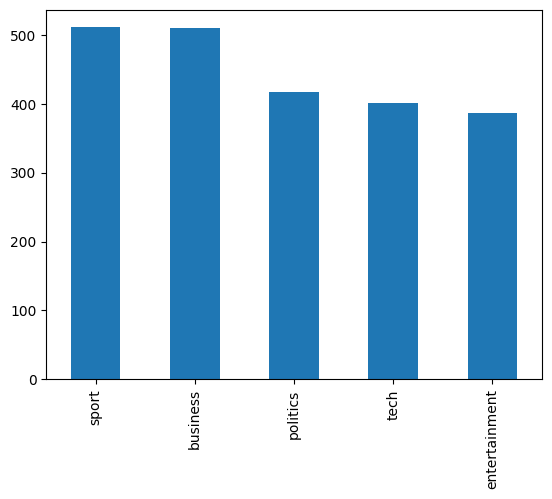

In [10]:
# Checking number of records of each label
df['label'].value_counts().sort_values(ascending=False).plot(kind='bar')

### Encode the labels into numeric

In [11]:
le = LabelEncoder()
df['label'] = le.fit_transform(df['label'])
list(le.classes_)

['business', 'entertainment', 'politics', 'sport', 'tech']

In [12]:
print(list(le.classes_), "\n" ,df.head())

['business', 'entertainment', 'politics', 'sport', 'tech'] 
    label                                               text
0      1    Musicians' groups are to tackle US visa regu...
1      1    U2, who have won three prestigious Grammy Aw...
2      1    Rock singer Pete Doherty has been involved i...
3      1    The film adaptation of Lemony Snicket novels...
4      1    Ocean's Twelve, the crime caper sequel starr...


### Perform preprocessing to text

In [13]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
#     text = re.sub(r'\W+', '', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text

In [14]:
df['text'] = df['text'].apply(clean_text)
df['text'] = df['text'].str.replace('\d+', '')
df.head()

/var/folders/b2/hx3hnjy967d2_x_0tbdd6xzc0000gn/T/ipykernel_1027/317573912.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df['text'] = df['text'].str.replace('\d+', '')


,label,text
0,1,musicians groups tackle us visa regulations bl...
1,1,u three prestigious grammy awards hit vertigo ...
2,1,rock singer pete doherty involved fight bands ...
3,1,film adaptation lemony snicket novels topped n...
4,1,oceans twelve crime caper sequel starring geor...


### Processing text for BERT model



In [208]:
def get_split(text1):
    l_total = []
    l_parcial = []
    if len(text1.split())//150 >0:
        n = len(text1.split())//150
    else: 
        n = 1
    for w in range(n):
        if w == 0:
            try:
                l_parcial = text1.split()[:200]
                l_total.append(" ".join(l_parcial))
            except:
                print("An exception occurred in w==",w)
        else:
            try:
                l_parcial = text1.split()[w*150:w*150 + 200]
                l_total.append(" ".join(l_parcial))
            except:
                print("An exception occurred w==",w)
    return l_total

In [16]:
df['text_split'] = df['text'].apply(get_split)
df.head()

,label,text,text_split
0,1,musicians groups tackle us visa regulations bl...,[musicians groups tackle us visa regulations b...
1,1,u three prestigious grammy awards hit vertigo ...,[u three prestigious grammy awards hit vertigo...
2,1,rock singer pete doherty involved fight bands ...,[rock singer pete doherty involved fight bands...
3,1,film adaptation lemony snicket novels topped n...,[film adaptation lemony snicket novels topped ...
4,1,oceans twelve crime caper sequel starring geor...,[oceans twelve crime caper sequel starring geo...


In [17]:
print(df['text_split'][1])
len([a for a in df['text'] if len(a.split())>150])

['u three prestigious grammy awards hit vertigo stubbornly clinging status one biggest bands world popular groups history rock several things common music must inspired appeal across generations distinctive always groundbreaking success music compelling performers charismatic intelligent enough make good decisions keep feet ground also want want biggest band ever stop wanting beatles rolling stones still rem hold onto queen catsuit u spades keep churning new album dismantle atomic bomb comes years schoolfriends got together dublin years joshua tree cemented place alltime rock alist may lost edginess raw youthful force propelled top lost none desire ability craft songs albums vertigo first single new album went straight uk singles chart number one knocking eminem top spot giving th top hit challenge bigger bolder better make records whole world listen bono recently said drummer larry mullen jr echoed sentiments competitive want radio big singles dont want thought veteran band band done 

1495

Setting output directory for BERT

In [18]:
# Set the output directory for saving model file
OUTPUT_DIR = './bert_news_category'

#@markdown Whether or not to clear/delete the directory and create a new one
DO_DELETE = True #@param {type:"boolean"}

if DO_DELETE:
    try:
        tf.io.gfile.DeleteRecursively(OUTPUT_DIR)
#         tf.compat.v1.gfile.DeleteRecursively(OUTPUT_DIR)
    except:
        pass

tf.io.gfile.makedirs(OUTPUT_DIR)
print('***** Model output directory: {} *****'.format(OUTPUT_DIR))

***** Model output directory: ./bert_news_category *****


### Split into 80% training and 20% validation

In [19]:
train, val = train_test_split(df, test_size=0.2, random_state=35)
train.reset_index(drop=True, inplace=True)
train.head(2)

,label,text,text_split
0,1,french film long engagement received nominati...,[french film long engagement received nominati...
1,0,russias renationalisation energy industry need...,[russias renationalisation energy industry nee...


In [20]:
# Get labels
label_list = [x for x in np.unique(train.label)]
label_list

[0, 1, 2, 3, 4]

In [21]:
val.reset_index(drop=True, inplace=True)
val.head(2)

,label,text,text_split
0,0,italian prime minister silvio berlusconi unvei...,[italian prime minister silvio berlusconi unve...
1,3,mexican outfit red sharks veracruz hope sign j...,[mexican outfit red sharks veracruz hope sign ...


### Check shape of train and validation data

In [22]:
val.shape, train.shape

((445, 3), (1780, 3))

In [23]:
train_l = []
label_l = []
index_l =[]

for idx,row in train.iterrows():
    for l in row['text_split']:
        train_l.append(l)
        label_l.append(row['label'])
        index_l.append(idx)
    
len(train_l), len(label_l), len(index_l)

(2168, 2168, 2168)

In [24]:
# p=0
# for idx,row in train.iterrows():
#     for l in row['text_split']:        
#         if len(row['text_split'])>1:
#             p=p+1
# print(p)

In [25]:
# print(train_l[:5],"\n", label_l[:5],"\n", index_l[:5])

In [26]:
val_l = []
val_label_l = []
val_index_l = []

for idx,row in val.iterrows():
    for l in row['text_split']:
        val_l.append(l)
        val_label_l.append(row['label'])
        val_index_l.append(idx)
            
len(val_l), len(val_label_l), len(val_index_l)

(546, 546, 546)

In [27]:
# p=0
# for idx,row in val.iterrows():
#     for l in row['text_split']:        
#         if len(row['text_split'])>1:
#             p=p+1
# print(p)

### Getting train and validation set as dataframe

In [28]:
train_df = pd.DataFrame({DATA_COLUMN:train_l, LABEL_COLUMN:label_l})
train_df.head()

,text,label
0,french film long engagement received nominatio...,1
1,russias renationalisation energy industry need...,0
2,lowbudget horror film produced evil dead direc...,1
3,users warned windows virus poses hugely popula...,4
4,news corp media company controlled australian ...,0


In [29]:
val_df = pd.DataFrame({DATA_COLUMN:val_l, LABEL_COLUMN:val_label_l})
val_df.head()

,text,label
0,italian prime minister silvio berlusconi unvei...,0
1,mexican outfit red sharks veracruz hope sign j...,3
2,french consumers increased spending january fi...,0
3,special adaptor helps people hand tremors cont...,4
4,arsene wenger stepped feud sir alex ferguson c...,3


In [30]:
# X_train, X_val, y_train, y_val = train_test_split(df['text'], df['label'], test_size=0.20, random_state=42)
# X_val

### Fine tuning the BERT model

The BERT model can be applied for any kind of classification task by fine-tuning it.

#### 1. Preparing the input data, i.e create **InputExample** using the BERT’s constructor.

In [31]:
# Use the InputExample class from BERT's run_classifier code to create examples from the data
train_InputExamples = train.apply(lambda x: run_classifier.InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this example
                                                                   text_a = x[DATA_COLUMN], 
                                                                   text_b = None, 
                                                                   label = x[LABEL_COLUMN]), axis = 1)

val_InputExamples = val.apply(lambda x: run_classifier.InputExample(guid=None, 
                                                                   text_a = x[DATA_COLUMN], 
                                                                   text_b = None, 
                                                                   label = x[LABEL_COLUMN]), axis = 1)

In [32]:
train_InputExamples


0       <run_classifier.InputExample object at 0x28566...
1       <run_classifier.InputExample object at 0x28566...
2       <run_classifier.InputExample object at 0x28566...
3       <run_classifier.InputExample object at 0x28566...
4       <run_classifier.InputExample object at 0x28566...
                              ...                        
1775    <run_classifier.InputExample object at 0x2856d...
1776    <run_classifier.InputExample object at 0x2856d...
1777    <run_classifier.InputExample object at 0x2856d...
1778    <run_classifier.InputExample object at 0x2856d...
1779    <run_classifier.InputExample object at 0x2856d...
Length: 1780, dtype: object

In [33]:
print("Row 0 - guid of training set : ", train_InputExamples.iloc[0].guid)
print("\n__________\nRow 0 - text_a of training set : ", train_InputExamples.iloc[0].text_a)
print("\n__________\nRow 0 - text_b of training set : ", train_InputExamples.iloc[0].text_b)
print("\n__________\nRow 0 - label of training set : ", train_InputExamples.iloc[0].label)

Row 0 - guid of training set :  None

__________
Row 0 - text_a of training set :  french film long engagement received  nominations frances cesar film awards despite recent ruling french enough world war romantic drama starring audrey tautou recently ruled american paris court partially backed warner bros cesar organisers modified rules allow film compete film directed jeanpierre jeunet received best actress picture director nominations last november court judged film american compete french film festivals two associations french producers challenged jeunets right french government subsidies warner bros backer ruling meant movie filmed france used french actors technicians eligible compete french prizes alain terzian president cesar organisers academie des arts et techniques du cinema said changes eligibility rules allow films french expression made three months prior court decision films best film category include police drama  quai des orfevres arnaud desplechins kings queen abdella

In [34]:
BERT_MODEL_HUB = "https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1"

def create_tokenizer_from_hub_module():
  """Get the vocab file and casing info from the Hub module."""
  with tf.Graph().as_default():
    bert_module = hub.Module(BERT_MODEL_HUB)
    tokenization_info = bert_module(signature="tokenization_info", as_dict=True)
    with tf.Session() as sess:
#     with tf.compat.v1.Session() as sess:
        vocab_file, do_lower_case = sess.run([tokenization_info["vocab_file"],
                                            tokenization_info["do_lower_case"]])
      
    return tokenization.FullTokenizer(
      vocab_file=vocab_file, do_lower_case=do_lower_case)

tokenizer = create_tokenizer_from_hub_module()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Metal device set to: Apple M1


2023-03-12 15:14:00.703140: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-03-12 15:14:00.703876: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-03-12 15:14:00.731903: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled
2023-03-12 15:14:00.768269: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-03-12 15:14:00.775216: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [35]:
# len(tokenizer.vocab.keys())

In [36]:
# print(tokenizer.vocab["##w"])

In [37]:
#Here is what the tokenised sample of the first training set observation looks like
print(tokenizer.tokenize(train_InputExamples.iloc[0].text_a))

['french', 'film', 'long', 'engagement', 'received', 'nominations', 'frances', 'cesar', 'film', 'awards', 'despite', 'recent', 'ruling', 'french', 'enough', 'world', 'war', 'romantic', 'drama', 'starring', 'audrey', 'taut', '##ou', 'recently', 'ruled', 'american', 'paris', 'court', 'partially', 'backed', 'warner', 'bros', 'cesar', 'organise', '##rs', 'modified', 'rules', 'allow', 'film', 'compete', 'film', 'directed', 'jean', '##pie', '##rre', 'je', '##une', '##t', 'received', 'best', 'actress', 'picture', 'director', 'nominations', 'last', 'november', 'court', 'judged', 'film', 'american', 'compete', 'french', 'film', 'festivals', 'two', 'associations', 'french', 'producers', 'challenged', 'je', '##une', '##ts', 'right', 'french', 'government', 'subsidies', 'warner', 'bros', 'back', '##er', 'ruling', 'meant', 'movie', 'filmed', 'france', 'used', 'french', 'actors', 'technicians', 'eligible', 'compete', 'french', 'prizes', 'alain', 'ter', '##zia', '##n', 'president', 'cesar', 'organise

#### 2. Converting the train and validation features to InputFeatures that BERT understands.

In [38]:
MAX_SEQ_LENGTH = 200

train_features = run_classifier.convert_examples_to_features(train_InputExamples, label_list, MAX_SEQ_LENGTH, tokenizer)

val_features = run_classifier.convert_examples_to_features(val_InputExamples, label_list, MAX_SEQ_LENGTH, tokenizer)

INFO:tensorflow:Writing example 0 of 1780


INFO:tensorflow:Writing example 0 of 1780


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] french film long engagement received nominations frances cesar film awards despite recent ruling french enough world war romantic drama starring audrey taut ##ou recently ruled american paris court partially backed warner bros cesar organise ##rs modified rules allow film compete film directed jean ##pie ##rre je ##une ##t received best actress picture director nominations last november court judged film american compete french film festivals two associations french producers challenged je ##une ##ts right french government subsidies warner bros back ##er ruling meant movie filmed france used french actors technicians eligible compete french prizes alain ter ##zia ##n president cesar organise ##rs academie des arts et techniques du cinema said changes eligibility rules allow films french expression made three months prior court decision films best film category include police drama qu ##ai des or ##fe ##vres ar ##naud des ##ple ##chin ##s kings queen abd #

INFO:tensorflow:tokens: [CLS] french film long engagement received nominations frances cesar film awards despite recent ruling french enough world war romantic drama starring audrey taut ##ou recently ruled american paris court partially backed warner bros cesar organise ##rs modified rules allow film compete film directed jean ##pie ##rre je ##une ##t received best actress picture director nominations last november court judged film american compete french film festivals two associations french producers challenged je ##une ##ts right french government subsidies warner bros back ##er ruling meant movie filmed france used french actors technicians eligible compete french prizes alain ter ##zia ##n president cesar organise ##rs academie des arts et techniques du cinema said changes eligibility rules allow films french expression made three months prior court decision films best film category include police drama qu ##ai des or ##fe ##vres ar ##naud des ##ple ##chin ##s kings queen abd #

INFO:tensorflow:input_ids: 101 2413 2143 2146 8147 2363 9930 10360 14923 2143 2982 2750 3522 6996 2413 2438 2088 2162 6298 3689 4626 14166 21642 7140 3728 5451 2137 3000 2457 6822 6153 6654 10243 14923 22933 2869 6310 3513 3499 2143 5566 2143 2856 3744 14756 14343 15333 9816 2102 2363 2190 3883 3861 2472 9930 2197 2281 2457 13224 2143 2137 5566 2413 2143 7519 2048 8924 2413 6443 8315 15333 9816 3215 2157 2413 2231 21762 6654 10243 2067 2121 6996 3214 3185 6361 2605 2109 2413 5889 20202 7792 5566 2413 11580 15654 28774 12871 2078 2343 14923 22933 2869 19669 4078 2840 3802 5461 4241 5988 2056 3431 11395 3513 3499 3152 2413 3670 2081 2093 2706 3188 2457 3247 3152 2190 2143 4696 2421 2610 3689 24209 4886 4078 2030 7959 24790 12098 26160 4078 10814 17231 2015 5465 3035 19935 8411 3775 2546 17710 5428 8376 4649 15549 3726 10360 2193 2028 2143 3482 7245 6610 7165 2190 5889 3817 8740 2618 19231 8785 17301 25933 20974 2594 5465 3035 11063 26536 17048 7165 11169 22047 2669 3393 15549 14756 2099 

INFO:tensorflow:input_ids: 101 2413 2143 2146 8147 2363 9930 10360 14923 2143 2982 2750 3522 6996 2413 2438 2088 2162 6298 3689 4626 14166 21642 7140 3728 5451 2137 3000 2457 6822 6153 6654 10243 14923 22933 2869 6310 3513 3499 2143 5566 2143 2856 3744 14756 14343 15333 9816 2102 2363 2190 3883 3861 2472 9930 2197 2281 2457 13224 2143 2137 5566 2413 2143 7519 2048 8924 2413 6443 8315 15333 9816 3215 2157 2413 2231 21762 6654 10243 2067 2121 6996 3214 3185 6361 2605 2109 2413 5889 20202 7792 5566 2413 11580 15654 28774 12871 2078 2343 14923 22933 2869 19669 4078 2840 3802 5461 4241 5988 2056 3431 11395 3513 3499 3152 2413 3670 2081 2093 2706 3188 2457 3247 3152 2190 2143 4696 2421 2610 3689 24209 4886 4078 2030 7959 24790 12098 26160 4078 10814 17231 2015 5465 3035 19935 8411 3775 2546 17710 5428 8376 4649 15549 3726 10360 2193 2028 2143 3482 7245 6610 7165 2190 5889 3817 8740 2618 19231 8785 17301 25933 20974 2594 5465 3035 11063 26536 17048 7165 11169 22047 2669 3393 15549 14756 2099 

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] russia ##s ren ##ation ##alis ##ation energy industry needs reversed senior government figure warned economy minister german gr ##ef told ko ##mmer ##sant newspaper direct state involvement oil un ##just ##ified comments follow sale much oil giant yu ##kos cover back taxes deal effectively took firms assets public ownership december another senior economic adviser called sale sw ##ind ##le century yu ##gan ##sk ##ne ##ft ##ega ##z unit produced yu ##kos output seized sold december less bn previously unknown firm called bai ##kal bai ##kal promptly passed hands state ##con ##tro ##lled firm ro ##s ##ne ##ft shortly merge state gas giant ga ##z ##pro ##m used see street hu ##stle ##rs kind thing andrei ill ##arion ##ov economic adviser president vladimir putin told press conference officials within days stripped responsibilities mr gr ##ef well ##k ##now ##n opponent national ##isation competitive parts market keen distance mr il ##ia ##ron ##ov ##s comments

INFO:tensorflow:tokens: [CLS] russia ##s ren ##ation ##alis ##ation energy industry needs reversed senior government figure warned economy minister german gr ##ef told ko ##mmer ##sant newspaper direct state involvement oil un ##just ##ified comments follow sale much oil giant yu ##kos cover back taxes deal effectively took firms assets public ownership december another senior economic adviser called sale sw ##ind ##le century yu ##gan ##sk ##ne ##ft ##ega ##z unit produced yu ##kos output seized sold december less bn previously unknown firm called bai ##kal bai ##kal promptly passed hands state ##con ##tro ##lled firm ro ##s ##ne ##ft shortly merge state gas giant ga ##z ##pro ##m used see street hu ##stle ##rs kind thing andrei ill ##arion ##ov economic adviser president vladimir putin told press conference officials within days stripped responsibilities mr gr ##ef well ##k ##now ##n opponent national ##isation competitive parts market keen distance mr il ##ia ##ron ##ov ##s comments

INFO:tensorflow:input_ids: 101 3607 2015 14916 3370 13911 3370 2943 3068 3791 11674 3026 2231 3275 7420 4610 2704 2446 24665 12879 2409 12849 15810 22341 3780 3622 2110 6624 3514 4895 29427 7810 7928 3582 5096 2172 3514 5016 9805 15710 3104 2067 7773 3066 6464 2165 9786 7045 2270 6095 2285 2178 3026 3171 11747 2170 5096 25430 22254 2571 2301 9805 5289 6711 2638 6199 29107 2480 3131 2550 9805 15710 6434 8243 2853 2285 2625 24869 3130 4242 3813 2170 21790 12902 21790 12902 13364 2979 2398 2110 8663 13181 11001 3813 20996 2015 2638 6199 3859 13590 2110 3806 5016 11721 2480 21572 2213 2109 2156 2395 15876 22516 2869 2785 2518 18125 5665 27548 4492 3171 11747 2343 8748 22072 2409 2811 3034 4584 2306 2420 10040 10198 2720 24665 12879 2092 2243 19779 2078 7116 2120 6648 6975 3033 3006 10326 3292 2720 6335 2401 4948 4492 2015 7928 26927 20203 26652 3316 9805 15710 1055 6649 8971 2056 13233 2231 2734 2131 3514 2228 20996 2015 2638 6199 9805 5289 6711 2638 6199 29107 2480 2468 2110 12384 2098 21

INFO:tensorflow:input_ids: 101 3607 2015 14916 3370 13911 3370 2943 3068 3791 11674 3026 2231 3275 7420 4610 2704 2446 24665 12879 2409 12849 15810 22341 3780 3622 2110 6624 3514 4895 29427 7810 7928 3582 5096 2172 3514 5016 9805 15710 3104 2067 7773 3066 6464 2165 9786 7045 2270 6095 2285 2178 3026 3171 11747 2170 5096 25430 22254 2571 2301 9805 5289 6711 2638 6199 29107 2480 3131 2550 9805 15710 6434 8243 2853 2285 2625 24869 3130 4242 3813 2170 21790 12902 21790 12902 13364 2979 2398 2110 8663 13181 11001 3813 20996 2015 2638 6199 3859 13590 2110 3806 5016 11721 2480 21572 2213 2109 2156 2395 15876 22516 2869 2785 2518 18125 5665 27548 4492 3171 11747 2343 8748 22072 2409 2811 3034 4584 2306 2420 10040 10198 2720 24665 12879 2092 2243 19779 2078 7116 2120 6648 6975 3033 3006 10326 3292 2720 6335 2401 4948 4492 2015 7928 26927 20203 26652 3316 9805 15710 1055 6649 8971 2056 13233 2231 2734 2131 3514 2228 20996 2015 2638 6199 9805 5289 6711 2638 6199 29107 2480 2468 2110 12384 2098 21

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] low ##bu ##dget horror film produced evil dead director sam rai ##mi topped north american box office boo ##ge ##yman focuses man returns childhood home confront traumatic past took m m three days last weeks chart ##top ##per robert de ni ##ro thriller hide seek fell number four new entries included wedding date comedy starring grace ##s debra messing number two road ##trip comedy yet multiple oscar nominee million dollar baby completed top five oscar contenders including aviator sideways continued perform strongly box office aviator taken m m far sideways taken m m limited release boo ##ge ##yman cost m m make performed well even though screened critics release normally sign film get bad reviews perform poorly box office certainly believe genre people going moved marketing materials movie critics say said rory br ##uer head distribution sony pictures released film us overall weekend box office strong despite fact american football ##s super bowl weekend t

INFO:tensorflow:tokens: [CLS] low ##bu ##dget horror film produced evil dead director sam rai ##mi topped north american box office boo ##ge ##yman focuses man returns childhood home confront traumatic past took m m three days last weeks chart ##top ##per robert de ni ##ro thriller hide seek fell number four new entries included wedding date comedy starring grace ##s debra messing number two road ##trip comedy yet multiple oscar nominee million dollar baby completed top five oscar contenders including aviator sideways continued perform strongly box office aviator taken m m far sideways taken m m limited release boo ##ge ##yman cost m m make performed well even though screened critics release normally sign film get bad reviews perform poorly box office certainly believe genre people going moved marketing materials movie critics say said rory br ##uer head distribution sony pictures released film us overall weekend box office strong despite fact american football ##s super bowl weekend t

INFO:tensorflow:input_ids: 101 2659 8569 24291 5469 2143 2550 4763 2757 2472 3520 15547 4328 9370 2167 2137 3482 2436 22017 3351 17906 7679 2158 5651 5593 2188 14323 19686 2627 2165 1049 1049 2093 2420 2197 3134 3673 14399 4842 2728 2139 9152 3217 10874 5342 6148 3062 2193 2176 2047 10445 2443 5030 3058 4038 4626 4519 2015 28762 22308 2193 2048 2346 24901 4038 2664 3674 7436 9773 2454 7922 3336 2949 2327 2274 7436 27236 2164 24035 12579 2506 4685 6118 3482 2436 24035 2579 1049 1049 2521 12579 2579 1049 1049 3132 2713 22017 3351 17906 3465 1049 1049 2191 2864 2092 2130 2295 12238 4401 2713 5373 3696 2143 2131 2919 4391 4685 9996 3482 2436 5121 2903 6907 2111 2183 2333 5821 4475 3185 4401 2360 2056 14285 7987 13094 2132 4353 8412 4620 2207 2143 2149 3452 5353 3482 2436 2844 2750 2755 2137 2374 2015 3565 4605 5353 2051 5988 20247 3227 2991 2095 2327 3152 17500 2105 1049 1049 4102 1055 3565 4605 5353 2561 3482 2436 1049 1049 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 2659 8569 24291 5469 2143 2550 4763 2757 2472 3520 15547 4328 9370 2167 2137 3482 2436 22017 3351 17906 7679 2158 5651 5593 2188 14323 19686 2627 2165 1049 1049 2093 2420 2197 3134 3673 14399 4842 2728 2139 9152 3217 10874 5342 6148 3062 2193 2176 2047 10445 2443 5030 3058 4038 4626 4519 2015 28762 22308 2193 2048 2346 24901 4038 2664 3674 7436 9773 2454 7922 3336 2949 2327 2274 7436 27236 2164 24035 12579 2506 4685 6118 3482 2436 24035 2579 1049 1049 2521 12579 2579 1049 1049 3132 2713 22017 3351 17906 3465 1049 1049 2191 2864 2092 2130 2295 12238 4401 2713 5373 3696 2143 2131 2919 4391 4685 9996 3482 2436 5121 2903 6907 2111 2183 2333 5821 4475 3185 4401 2360 2056 14285 7987 13094 2132 4353 8412 4620 2207 2143 2149 3452 5353 3482 2436 2844 2750 2755 2137 2374 2015 3565 4605 5353 2051 5988 20247 3227 2991 2095 2327 3152 17500 2105 1049 1049 4102 1055 3565 4605 5353 2561 3482 2436 1049 1049 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] users warned windows virus poses hugely popular te ##tri ##s game cell ##ery worm install ##s playable version classic falling blocks game pcs infected users play game worm spends time using machine search new victims in ##fect nearby networks risk infection cell ##ery thought low copies worm found wild cell ##ery worm spread via email like many viruses instead brows ##es computer networks pcs shut ins ##ecure ways connect machines in ##fect ##s machine cell ##ery install ##s version te ##tri ##s users play game starts worm also starts music file accompany time virus starts sc ##ouring networks vulnerable machines virus damage machines heavily infected networks could slow scanning traffic builds productivity may suffer users spend time playing te ##tri ##s pcs running windows nt xp could vulnerable worm company culture allowing games played office staff may believe simply new game installed rather something cause concern said graham cl ##ule ##y spokesman 

INFO:tensorflow:tokens: [CLS] users warned windows virus poses hugely popular te ##tri ##s game cell ##ery worm install ##s playable version classic falling blocks game pcs infected users play game worm spends time using machine search new victims in ##fect nearby networks risk infection cell ##ery thought low copies worm found wild cell ##ery worm spread via email like many viruses instead brows ##es computer networks pcs shut ins ##ecure ways connect machines in ##fect ##s machine cell ##ery install ##s version te ##tri ##s users play game starts worm also starts music file accompany time virus starts sc ##ouring networks vulnerable machines virus damage machines heavily infected networks could slow scanning traffic builds productivity may suffer users spend time playing te ##tri ##s pcs running windows nt xp could vulnerable worm company culture allowing games played office staff may believe simply new game installed rather something cause concern said graham cl ##ule ##y spokesman 

INFO:tensorflow:input_ids: 101 5198 7420 3645 7865 22382 27564 2759 8915 18886 2015 2208 3526 7301 15485 16500 2015 16854 2544 4438 4634 5991 2208 27019 10372 5198 2377 2208 15485 15970 2051 2478 3698 3945 2047 5694 1999 25969 3518 6125 3891 8985 3526 7301 2245 2659 4809 15485 2179 3748 3526 7301 15485 3659 3081 10373 2066 2116 18191 2612 11347 2229 3274 6125 27019 3844 16021 29150 3971 7532 6681 1999 25969 2015 3698 3526 7301 16500 2015 2544 8915 18886 2015 5198 2377 2208 4627 15485 2036 4627 2189 5371 12673 2051 7865 4627 8040 27897 6125 8211 6681 7865 4053 6681 4600 10372 6125 2071 4030 13722 4026 16473 15836 2089 9015 5198 5247 2051 2652 8915 18886 2015 27019 2770 3645 23961 26726 2071 8211 15485 2194 3226 4352 2399 2209 2436 3095 2089 2903 3432 2047 2208 5361 2738 2242 3426 5142 2056 5846 18856 9307 2100 14056 3424 23350 3813 2061 8458 2891 2521 2193 2111 10372 3526 7301 2245 2235 10831 8985 2659 2061 8458 2891 9720 5198 3316 10651 3424 23350 4007 2562 5123 102 0 0 0 0 0 0 0 0 0 0

INFO:tensorflow:input_ids: 101 5198 7420 3645 7865 22382 27564 2759 8915 18886 2015 2208 3526 7301 15485 16500 2015 16854 2544 4438 4634 5991 2208 27019 10372 5198 2377 2208 15485 15970 2051 2478 3698 3945 2047 5694 1999 25969 3518 6125 3891 8985 3526 7301 2245 2659 4809 15485 2179 3748 3526 7301 15485 3659 3081 10373 2066 2116 18191 2612 11347 2229 3274 6125 27019 3844 16021 29150 3971 7532 6681 1999 25969 2015 3698 3526 7301 16500 2015 2544 8915 18886 2015 5198 2377 2208 4627 15485 2036 4627 2189 5371 12673 2051 7865 4627 8040 27897 6125 8211 6681 7865 4053 6681 4600 10372 6125 2071 4030 13722 4026 16473 15836 2089 9015 5198 5247 2051 2652 8915 18886 2015 27019 2770 3645 23961 26726 2071 8211 15485 2194 3226 4352 2399 2209 2436 3095 2089 2903 3432 2047 2208 5361 2738 2242 3426 5142 2056 5846 18856 9307 2100 14056 3424 23350 3813 2061 8458 2891 2521 2193 2111 10372 3526 7301 2245 2235 10831 8985 2659 2061 8458 2891 9720 5198 3316 10651 3424 23350 4007 2562 5123 102 0 0 0 0 0 0 0 0 0 0

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 4 (id = 4)


INFO:tensorflow:label: 4 (id = 4)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] news corp media company controlled australian billionaire rupert murdoch eyeing move video games market according financial times chief operating officer peter cher ##nin said news corp kicking tires pretty much video games companies santa monica ##base ##d act ##iv ##ison said one firm takeover list video games big business paper quoted mr cher ##nin saying would like get success products sony ##s playstation microsoft ##s xbox nintendo ##s game cube boosted demand video games days arcade classics space invaders pac ##man donkey kong long gone today games often budgets big enough feature films look give gamer ##s real experience possible price tags reflecting heavy investment development companies video games proving almost profitable fun mr cher ##nin however told ft news corp finding difficult identify suitable target struggling gap companies like electronic arts comes high price tag next tier companies explained conference phoenix arizona may focused o

INFO:tensorflow:tokens: [CLS] news corp media company controlled australian billionaire rupert murdoch eyeing move video games market according financial times chief operating officer peter cher ##nin said news corp kicking tires pretty much video games companies santa monica ##base ##d act ##iv ##ison said one firm takeover list video games big business paper quoted mr cher ##nin saying would like get success products sony ##s playstation microsoft ##s xbox nintendo ##s game cube boosted demand video games days arcade classics space invaders pac ##man donkey kong long gone today games often budgets big enough feature films look give gamer ##s real experience possible price tags reflecting heavy investment development companies video games proving almost profitable fun mr cher ##nin however told ft news corp finding difficult identify suitable target struggling gap companies like electronic arts comes high price tag next tier companies explained conference phoenix arizona may focused o

INFO:tensorflow:input_ids: 101 2739 13058 2865 2194 4758 2827 22301 14641 19954 19285 2693 2678 2399 3006 2429 3361 2335 2708 4082 2961 2848 24188 11483 2056 2739 13058 10209 13310 3492 2172 2678 2399 3316 4203 9018 15058 2094 2552 12848 10929 2056 2028 3813 15336 2862 2678 2399 2502 2449 3259 9339 2720 24188 11483 3038 2052 2066 2131 3112 3688 8412 2015 9160 7513 2015 12202 10022 2015 2208 14291 28043 5157 2678 2399 2420 10877 10002 2686 17347 14397 2386 20325 4290 2146 2908 2651 2399 2411 26178 2502 2438 3444 3152 2298 2507 27911 2015 2613 3325 2825 3976 22073 10842 3082 5211 2458 3316 2678 2399 13946 2471 15282 4569 2720 24188 11483 2174 2409 3027 2739 13058 4531 3697 6709 7218 4539 8084 6578 3316 2066 4816 2840 3310 2152 3976 6415 2279 7563 3316 4541 3034 6708 5334 2089 4208 2028 2048 4031 3210 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 2739 13058 2865 2194 4758 2827 22301 14641 19954 19285 2693 2678 2399 3006 2429 3361 2335 2708 4082 2961 2848 24188 11483 2056 2739 13058 10209 13310 3492 2172 2678 2399 3316 4203 9018 15058 2094 2552 12848 10929 2056 2028 3813 15336 2862 2678 2399 2502 2449 3259 9339 2720 24188 11483 3038 2052 2066 2131 3112 3688 8412 2015 9160 7513 2015 12202 10022 2015 2208 14291 28043 5157 2678 2399 2420 10877 10002 2686 17347 14397 2386 20325 4290 2146 2908 2651 2399 2411 26178 2502 2438 3444 3152 2298 2507 27911 2015 2613 3325 2825 3976 22073 10842 3082 5211 2458 3316 2678 2399 13946 2471 15282 4569 2720 24188 11483 2174 2409 3027 2739 13058 4531 3697 6709 7218 4539 8084 6578 3316 2066 4816 2840 3310 2152 3976 6415 2279 7563 3316 4541 3034 6708 5334 2089 4208 2028 2048 4031 3210 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:Writing example 0 of 445


INFO:tensorflow:Writing example 0 of 445


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] italian prime minister silvio be ##rl ##us ##con ##i un ##ve ##il plans aimed kicks ##tar ##ting country ##s sp ##utter ##ing economy thursday night rome present action plan development italy meeting industrialist ##s trade union leaders mr be ##rl ##us ##con ##i expected table reforms aimed boost ##ing research development rd spending competitive ##ness small firms also focus bankruptcy laws slow pace legal system prime minister scheduled start meeting gm ##t government accused under ##fu ##nding rd making harder italy compete european nations leading brain ##dra ##in country ##s brightest talents analysts say hiring firing staff still difficult expensive ham ##per ##ing development small medium ##si ##zed businesses result say italy ##s corporate landscape filled numerous smaller companies often reluctant become bigger extra has ##sle would accompany running larger firm time bankruptcy laws make difficult failed company directors set new businesses emerg

INFO:tensorflow:tokens: [CLS] italian prime minister silvio be ##rl ##us ##con ##i un ##ve ##il plans aimed kicks ##tar ##ting country ##s sp ##utter ##ing economy thursday night rome present action plan development italy meeting industrialist ##s trade union leaders mr be ##rl ##us ##con ##i expected table reforms aimed boost ##ing research development rd spending competitive ##ness small firms also focus bankruptcy laws slow pace legal system prime minister scheduled start meeting gm ##t government accused under ##fu ##nding rd making harder italy compete european nations leading brain ##dra ##in country ##s brightest talents analysts say hiring firing staff still difficult expensive ham ##per ##ing development small medium ##si ##zed businesses result say italy ##s corporate landscape filled numerous smaller companies often reluctant become bigger extra has ##sle would accompany running larger firm time bankruptcy laws make difficult failed company directors set new businesses emerg

INFO:tensorflow:input_ids: 101 3059 3539 2704 28107 2022 12190 2271 8663 2072 4895 3726 4014 3488 6461 14590 7559 3436 2406 2015 11867 26878 2075 4610 9432 2305 4199 2556 2895 2933 2458 3304 3116 21691 2015 3119 2586 4177 2720 2022 12190 2271 8663 2072 3517 2795 8818 6461 12992 2075 2470 2458 16428 5938 6975 2791 2235 9786 2036 3579 10528 4277 4030 6393 3423 2291 3539 2704 5115 2707 3116 13938 2102 2231 5496 2104 11263 15683 16428 2437 6211 3304 5566 2647 3741 2877 4167 7265 2378 2406 2015 26849 11725 18288 2360 14763 7493 3095 2145 3697 6450 10654 4842 2075 2458 2235 5396 5332 5422 5661 2765 2360 3304 2015 5971 5957 3561 3365 3760 3316 2411 11542 2468 7046 4469 2038 25016 2052 12673 2770 3469 3813 2051 10528 4277 2191 3697 3478 2194 5501 2275 2047 5661 12636 13930 3663 10654 4842 2075 3304 2015 10670 4818 4382 2231 2758 2275 26997 2989 3471 5815 2893 3930 2183 5368 3304 2015 2454 2313 2429 6335 7082 10848 3304 2015 2449 3780 2231 3579 3098 6089 6502 2470 2437 21134 2800 10528 2375 403

INFO:tensorflow:input_ids: 101 3059 3539 2704 28107 2022 12190 2271 8663 2072 4895 3726 4014 3488 6461 14590 7559 3436 2406 2015 11867 26878 2075 4610 9432 2305 4199 2556 2895 2933 2458 3304 3116 21691 2015 3119 2586 4177 2720 2022 12190 2271 8663 2072 3517 2795 8818 6461 12992 2075 2470 2458 16428 5938 6975 2791 2235 9786 2036 3579 10528 4277 4030 6393 3423 2291 3539 2704 5115 2707 3116 13938 2102 2231 5496 2104 11263 15683 16428 2437 6211 3304 5566 2647 3741 2877 4167 7265 2378 2406 2015 26849 11725 18288 2360 14763 7493 3095 2145 3697 6450 10654 4842 2075 2458 2235 5396 5332 5422 5661 2765 2360 3304 2015 5971 5957 3561 3365 3760 3316 2411 11542 2468 7046 4469 2038 25016 2052 12673 2770 3469 3813 2051 10528 4277 2191 3697 3478 2194 5501 2275 2047 5661 12636 13930 3663 10654 4842 2075 3304 2015 10670 4818 4382 2231 2758 2275 26997 2989 3471 5815 2893 3930 2183 5368 3304 2015 2454 2313 2429 6335 7082 10848 3304 2015 2449 3780 2231 3579 3098 6089 6502 2470 2437 21134 2800 10528 2375 403

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] mexican outfit red sharks veracruz hope sign jun ##inho brazilian decides leave celtic frustrated lack first ##tea ##m action president gustavo parent ##e sanchez says jun ##inho wish remain scottish football anymore agent brian has ##sell insists year ##old brazilian midfielder determined win back place manager going pick that ##s different ball game told sun that ##s something wed look jun ##inho deserves respect little kid has ##sell warns jun ##inho could rec ##ons ##ider future celtic unless given run games end january transfer window jun ##inho signed middlesbrough summer failed live high expectations lost place year ##old aiden mc ##ge ##ady caps brazil he ##s best signing celtic ever made insisted has ##sell wants play martin one ##ill martin one ##ill want play jun ##inho someone come celtic ranks deserves much respect sanchez bull ##ish hopes pri ##sing jun ##inho scottish champions although has ##sell believes mexico would preferred destination 

INFO:tensorflow:tokens: [CLS] mexican outfit red sharks veracruz hope sign jun ##inho brazilian decides leave celtic frustrated lack first ##tea ##m action president gustavo parent ##e sanchez says jun ##inho wish remain scottish football anymore agent brian has ##sell insists year ##old brazilian midfielder determined win back place manager going pick that ##s different ball game told sun that ##s something wed look jun ##inho deserves respect little kid has ##sell warns jun ##inho could rec ##ons ##ider future celtic unless given run games end january transfer window jun ##inho signed middlesbrough summer failed live high expectations lost place year ##old aiden mc ##ge ##ady caps brazil he ##s best signing celtic ever made insisted has ##sell wants play martin one ##ill martin one ##ill want play jun ##inho someone come celtic ranks deserves much respect sanchez bull ##ish hopes pri ##sing jun ##inho scottish champions although has ##sell believes mexico would preferred destination 

INFO:tensorflow:input_ids: 101 4916 11018 2417 12004 23741 3246 3696 12022 29344 6142 7288 2681 8730 10206 3768 2034 27058 2213 2895 2343 24801 6687 2063 10568 2758 12022 29344 4299 3961 4104 2374 4902 4005 4422 2038 23836 16818 2095 11614 6142 8850 4340 2663 2067 2173 3208 2183 4060 2008 2015 2367 3608 2208 2409 3103 2008 2015 2242 21981 2298 12022 29344 17210 4847 2210 4845 2038 23836 19428 12022 29344 2071 28667 5644 18688 2925 8730 4983 2445 2448 2399 2203 2254 4651 3332 12022 29344 2772 21655 2621 3478 2444 2152 10908 2439 2173 2095 11614 15086 11338 3351 18632 9700 4380 2002 2015 2190 6608 8730 2412 2081 7278 2038 23836 4122 2377 3235 2028 8591 3235 2028 8591 2215 2377 12022 29344 2619 2272 8730 6938 17210 2172 4847 10568 7087 4509 8069 26927 7741 12022 29344 4104 3966 2348 2038 23836 7164 3290 2052 6871 7688 2525 5287 12022 29344 2056 3813 3749 2252 3577 23741 7688 10568 2409 4184 2880 4037 8730 3208 2028 8591 4847 2121 5891 2015 2006 2271 12022 29344 2486 2126 2136 2056 2867 21

INFO:tensorflow:input_ids: 101 4916 11018 2417 12004 23741 3246 3696 12022 29344 6142 7288 2681 8730 10206 3768 2034 27058 2213 2895 2343 24801 6687 2063 10568 2758 12022 29344 4299 3961 4104 2374 4902 4005 4422 2038 23836 16818 2095 11614 6142 8850 4340 2663 2067 2173 3208 2183 4060 2008 2015 2367 3608 2208 2409 3103 2008 2015 2242 21981 2298 12022 29344 17210 4847 2210 4845 2038 23836 19428 12022 29344 2071 28667 5644 18688 2925 8730 4983 2445 2448 2399 2203 2254 4651 3332 12022 29344 2772 21655 2621 3478 2444 2152 10908 2439 2173 2095 11614 15086 11338 3351 18632 9700 4380 2002 2015 2190 6608 8730 2412 2081 7278 2038 23836 4122 2377 3235 2028 8591 3235 2028 8591 2215 2377 12022 29344 2619 2272 8730 6938 17210 2172 4847 10568 7087 4509 8069 26927 7741 12022 29344 4104 3966 2348 2038 23836 7164 3290 2052 6871 7688 2525 5287 12022 29344 2056 3813 3749 2252 3577 23741 7688 10568 2409 4184 2880 4037 8730 3208 2028 8591 4847 2121 5891 2015 2006 2271 12022 29344 2486 2126 2136 2056 2867 21

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 3 (id = 3)


INFO:tensorflow:label: 3 (id = 3)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] french consumers increased spending january figure bo ##des well country ##s economic growth figures revealed national stat ##istic institute ins ##ee added consumer spending january rose year ##ony ##ear basis rising sales household equipment behind increase ins ##ee also said french consumer prices fell january annual basis despite general increase spending january french households bought fewer cars january according ins ##ee car sales fell january following fall december year ##ony ##ear basis sector still saw sales increase consumer spending fuel ##led frances economic growth last quarter analysts expect continue support economy growth remain fragile vulnerable risks like strong rise long ##ter ##m interest rates tension oil price emmanuel ferry ex ##ane bn ##p par ##iba ##s told reuters news agency meanwhile italy consumer confidence rose highest level since october economic research group isa ##e said italian consumer confidence rose despite slight 

INFO:tensorflow:tokens: [CLS] french consumers increased spending january figure bo ##des well country ##s economic growth figures revealed national stat ##istic institute ins ##ee added consumer spending january rose year ##ony ##ear basis rising sales household equipment behind increase ins ##ee also said french consumer prices fell january annual basis despite general increase spending january french households bought fewer cars january according ins ##ee car sales fell january following fall december year ##ony ##ear basis sector still saw sales increase consumer spending fuel ##led frances economic growth last quarter analysts expect continue support economy growth remain fragile vulnerable risks like strong rise long ##ter ##m interest rates tension oil price emmanuel ferry ex ##ane bn ##p par ##iba ##s told reuters news agency meanwhile italy consumer confidence rose highest level since october economic research group isa ##e said italian consumer confidence rose despite slight 

INFO:tensorflow:input_ids: 101 2413 10390 3445 5938 2254 3275 8945 6155 2092 2406 2015 3171 3930 4481 3936 2120 28093 6553 2820 16021 4402 2794 7325 5938 2254 3123 2095 16585 14644 3978 4803 4341 4398 3941 2369 3623 16021 4402 2036 2056 2413 7325 7597 3062 2254 3296 3978 2750 2236 3623 5938 2254 2413 3911 4149 8491 3765 2254 2429 16021 4402 2482 4341 3062 2254 2206 2991 2285 2095 16585 14644 3978 4753 2145 2387 4341 3623 7325 5938 4762 3709 10360 3171 3930 2197 4284 18288 5987 3613 2490 4610 3930 3961 13072 8211 10831 2066 2844 4125 2146 3334 2213 3037 6165 6980 3514 3976 14459 7115 4654 7231 24869 2361 11968 18410 2015 2409 26665 2739 4034 5564 3304 7325 7023 3123 3284 2504 2144 2255 3171 2470 2177 18061 2063 2056 3059 7325 7023 3123 2750 7263 26118 2460 3334 2213 15792 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 2413 10390 3445 5938 2254 3275 8945 6155 2092 2406 2015 3171 3930 4481 3936 2120 28093 6553 2820 16021 4402 2794 7325 5938 2254 3123 2095 16585 14644 3978 4803 4341 4398 3941 2369 3623 16021 4402 2036 2056 2413 7325 7597 3062 2254 3296 3978 2750 2236 3623 5938 2254 2413 3911 4149 8491 3765 2254 2429 16021 4402 2482 4341 3062 2254 2206 2991 2285 2095 16585 14644 3978 4753 2145 2387 4341 3623 7325 5938 4762 3709 10360 3171 3930 2197 4284 18288 5987 3613 2490 4610 3930 3961 13072 8211 10831 2066 2844 4125 2146 3334 2213 3037 6165 6980 3514 3976 14459 7115 4654 7231 24869 2361 11968 18410 2015 2409 26665 2739 4034 5564 3304 7325 7023 3123 3284 2504 2144 2255 3171 2470 2177 18061 2063 2056 3059 7325 7023 3123 2750 7263 26118 2460 3334 2213 15792 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] special adapt ##or helps people hand tremor ##s control computer mouse easily developed device uses similar steady cam technology found cam ##cor ##ders filter shaking hand movements people hand tremor ##s find hard use conventional mice simple computer tasks erratic movements cu ##rso ##r screen three million brit ##ons sort hand tremor condition said uk national tremor foundation using computer mouse well known extremely hard people tremor ##s delighted hear technology developed address problem said karen walsh uk national tremor foundation commonly associated tremor ##s parkinson ##s disease also caused conditions like essential tremor et tremor ##s often affect older people hit ages et example genetic af ##flict people throughout lives assist ##ive mouse adapt ##er ama brain ##child ibm researcher jim levine developed prototype seeing uncle parkinson ##s disease struggle mouse control knew must way improve situation millions tremor suffer ##ers around 

INFO:tensorflow:tokens: [CLS] special adapt ##or helps people hand tremor ##s control computer mouse easily developed device uses similar steady cam technology found cam ##cor ##ders filter shaking hand movements people hand tremor ##s find hard use conventional mice simple computer tasks erratic movements cu ##rso ##r screen three million brit ##ons sort hand tremor condition said uk national tremor foundation using computer mouse well known extremely hard people tremor ##s delighted hear technology developed address problem said karen walsh uk national tremor foundation commonly associated tremor ##s parkinson ##s disease also caused conditions like essential tremor et tremor ##s often affect older people hit ages et example genetic af ##flict people throughout lives assist ##ive mouse adapt ##er ama brain ##child ibm researcher jim levine developed prototype seeing uncle parkinson ##s disease struggle mouse control knew must way improve situation millions tremor suffer ##ers around 

INFO:tensorflow:input_ids: 101 2569 15581 2953 7126 2111 2192 27734 2015 2491 3274 8000 4089 2764 5080 3594 2714 6706 11503 2974 2179 11503 27108 13375 11307 5513 2192 5750 2111 2192 27734 2015 2424 2524 2224 7511 12328 3722 3274 8518 24122 5750 12731 25301 2099 3898 2093 2454 28101 5644 4066 2192 27734 4650 2056 2866 2120 27734 3192 2478 3274 8000 2092 2124 5186 2524 2111 27734 2015 15936 2963 2974 2764 4769 3291 2056 8129 11019 2866 2120 27734 3192 4141 3378 27734 2015 20310 2015 4295 2036 3303 3785 2066 6827 27734 3802 27734 2015 2411 7461 3080 2111 2718 5535 3802 2742 7403 21358 29301 2111 2802 3268 6509 3512 8000 15581 2121 25933 4167 19339 9980 10753 3958 17780 2764 8773 3773 4470 20310 2015 4295 5998 8000 2491 2354 2442 2126 5335 3663 8817 27734 9015 2545 2105 2088 2164 9750 2193 9750 3274 5198 3623 2313 5535 2051 2342 3274 3229 7502 2056 3274 5198 13354 5080 7473 10426 5834 5729 27734 2036 2583 17614 3674 22042 8000 6462 3303 15311 16648 9980 2056 2052 4256 2235 2866 15058 2094

INFO:tensorflow:input_ids: 101 2569 15581 2953 7126 2111 2192 27734 2015 2491 3274 8000 4089 2764 5080 3594 2714 6706 11503 2974 2179 11503 27108 13375 11307 5513 2192 5750 2111 2192 27734 2015 2424 2524 2224 7511 12328 3722 3274 8518 24122 5750 12731 25301 2099 3898 2093 2454 28101 5644 4066 2192 27734 4650 2056 2866 2120 27734 3192 2478 3274 8000 2092 2124 5186 2524 2111 27734 2015 15936 2963 2974 2764 4769 3291 2056 8129 11019 2866 2120 27734 3192 4141 3378 27734 2015 20310 2015 4295 2036 3303 3785 2066 6827 27734 3802 27734 2015 2411 7461 3080 2111 2718 5535 3802 2742 7403 21358 29301 2111 2802 3268 6509 3512 8000 15581 2121 25933 4167 19339 9980 10753 3958 17780 2764 8773 3773 4470 20310 2015 4295 5998 8000 2491 2354 2442 2126 5335 3663 8817 27734 9015 2545 2105 2088 2164 9750 2193 9750 3274 5198 3623 2313 5535 2051 2342 3274 3229 7502 2056 3274 5198 13354 5080 7473 10426 5834 5729 27734 2036 2583 17614 3674 22042 8000 6462 3303 15311 16648 9980 2056 2052 4256 2235 2866 15058 2094

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 4 (id = 4)


INFO:tensorflow:label: 4 (id = 4)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] ars ##ene wen ##ger stepped feud sir alex ferguson claiming manchester united manager guilty bringing football di ##sr ##ep ##ute pairs long ##run ##ning row put back headlines saturday ferguson said arsenal counterpart disgrace wen ##ger initially refused bite back saying never answer questions man claims ferguson punished football association latest twist ferguson ##wen ##ger saga came saturday united boss interview independent newspaper discussed events game two sides october united day old trafford game followed notorious food fight saw ferguson ##s clothes covered soup pizza sides meet high ##bury february tunnel wen ##ger critic ##ising players calling cheat ##s told leave alone behave ferguson said saturday ran hands raised saying want ap ##olo ##gis ##e behaviour players another manager un ##thi ##nka ##ble disgrace don ##t expect wen ##ger ever ap ##olo ##gis ##e he ##s type person allegations put wen ##ger saturdays game bolton arsenal lost slip 

INFO:tensorflow:tokens: [CLS] ars ##ene wen ##ger stepped feud sir alex ferguson claiming manchester united manager guilty bringing football di ##sr ##ep ##ute pairs long ##run ##ning row put back headlines saturday ferguson said arsenal counterpart disgrace wen ##ger initially refused bite back saying never answer questions man claims ferguson punished football association latest twist ferguson ##wen ##ger saga came saturday united boss interview independent newspaper discussed events game two sides october united day old trafford game followed notorious food fight saw ferguson ##s clothes covered soup pizza sides meet high ##bury february tunnel wen ##ger critic ##ising players calling cheat ##s told leave alone behave ferguson said saturday ran hands raised saying want ap ##olo ##gis ##e behaviour players another manager un ##thi ##nka ##ble disgrace don ##t expect wen ##ger ever ap ##olo ##gis ##e he ##s type person allegations put wen ##ger saturdays game bolton arsenal lost slip 

INFO:tensorflow:input_ids: 101 29393 8625 19181 4590 3706 13552 2909 4074 11262 6815 5087 2142 3208 5905 5026 2374 4487 21338 13699 10421 7689 2146 15532 5582 5216 2404 2067 19377 5095 11262 2056 9433 13637 29591 19181 4590 3322 4188 6805 2067 3038 2196 3437 3980 2158 4447 11262 14248 2374 2523 6745 9792 11262 12449 4590 12312 2234 5095 2142 5795 4357 2981 3780 6936 2824 2208 2048 3903 2255 2142 2154 2214 26894 2208 2628 12536 2833 2954 2387 11262 2015 4253 3139 11350 10733 3903 3113 2152 4917 2337 5234 19181 4590 6232 9355 2867 4214 21910 2015 2409 2681 2894 16582 11262 2056 5095 2743 2398 2992 3038 2215 9706 12898 17701 2063 9164 2867 2178 3208 4895 15222 25804 3468 29591 2123 2102 5987 19181 4590 2412 9706 12898 17701 2063 2002 2015 2828 2711 9989 2404 19181 4590 18860 2208 12118 9433 2439 7540 2685 2369 9295 2516 2679 2034 2056 4921 2063 2467 8335 2466 2409 2498 3047 2831 7566 4122 2191 3780 3720 3084 3780 3720 2987 2102 3037 2987 2102 3043 2196 3437 4013 19152 7777 2563 4312 2175 

INFO:tensorflow:input_ids: 101 29393 8625 19181 4590 3706 13552 2909 4074 11262 6815 5087 2142 3208 5905 5026 2374 4487 21338 13699 10421 7689 2146 15532 5582 5216 2404 2067 19377 5095 11262 2056 9433 13637 29591 19181 4590 3322 4188 6805 2067 3038 2196 3437 3980 2158 4447 11262 14248 2374 2523 6745 9792 11262 12449 4590 12312 2234 5095 2142 5795 4357 2981 3780 6936 2824 2208 2048 3903 2255 2142 2154 2214 26894 2208 2628 12536 2833 2954 2387 11262 2015 4253 3139 11350 10733 3903 3113 2152 4917 2337 5234 19181 4590 6232 9355 2867 4214 21910 2015 2409 2681 2894 16582 11262 2056 5095 2743 2398 2992 3038 2215 9706 12898 17701 2063 9164 2867 2178 3208 4895 15222 25804 3468 29591 2123 2102 5987 19181 4590 2412 9706 12898 17701 2063 2002 2015 2828 2711 9989 2404 19181 4590 18860 2208 12118 9433 2439 7540 2685 2369 9295 2516 2679 2034 2056 4921 2063 2467 8335 2466 2409 2498 3047 2831 7566 4122 2191 3780 3720 3084 3780 3720 2987 2102 3037 2987 2102 3043 2196 3437 4013 19152 7777 2563 4312 2175 

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 3 (id = 3)


INFO:tensorflow:label: 3 (id = 3)


In [39]:
#Example on first observation in the training set
print("Sentence : ", train_InputExamples.iloc[80].text_a)
print("-"*30)
print("Tokens : ", tokenizer.tokenize(train_InputExamples.iloc[80].text_a))
print("-"*30)
print("Input IDs : ", train_features[80].input_ids)
print("-"*30)
print("Input Masks : ", train_features[80].input_mask)
print("-"*30)
print("Segment IDs : ", train_features[80].segment_ids)

Sentence :  talks aimed averting series national strikes pensions reforms take place weekend five public sector unions hold private talks deputy prime minister john prescott labours spring conference gateshead want government withdraw regulations due introduced weeks would raise pension age council workers   m workers could take part strike already earmarked  march however sides anxious avoid major confrontation run general election said bbc labour affairs correspondent stephen cape four days britains biggest union unison start balloting   local government workers strikes public sector unions pledged follow weeks new regulations introduced raise pension age local government workers five unions meeting mr prescott want government withdraw regulations would allow months tough negotiations follow said correspondent spokesman mr prescott warned changes local government pension scheme would go ahead april privately ministers believe less painful option correspondent added public commercial 

### Creating prediction model

In [40]:
def create_model(is_predicting, input_ids, input_mask, segment_ids, labels,
                 num_labels):
  
    bert_module = hub.Module(
        BERT_MODEL_HUB,
        trainable=True)
    bert_inputs = dict(
      input_ids=input_ids,
      input_mask=input_mask,
      segment_ids=segment_ids)
    bert_outputs = bert_module(
      inputs=bert_inputs,
      signature="tokens",
      as_dict=True)

    # Use "pooled_output" for classification tasks on an entire sentence.
    # Use "sequence_outputs" for token-level output.
    output_layer = bert_outputs["pooled_output"]
    # with tf.Session() as sess:
    output_layer1 = bert_outputs["pooled_output"]
    # output_layer1 = 999
    hidden_size = output_layer.shape[-1].value

    # Create our own layer to tune for politeness data.
    output_weights = tf.get_variable(
      "output_weights", [num_labels, hidden_size],
      initializer=tf.truncated_normal_initializer(stddev=0.02))

    output_bias = tf.get_variable(
      "output_bias", [num_labels], initializer=tf.zeros_initializer())

    with tf.variable_scope("loss"):

        # Dropout helps prevent overfitting
        output_layer = tf.nn.dropout(output_layer, keep_prob=0.8)

        logits = tf.matmul(output_layer, output_weights, transpose_b=True)
        logits = tf.nn.bias_add(logits, output_bias)
        log_probs = tf.nn.log_softmax(logits, axis=-1)

        # Convert labels into one-hot encoding
        one_hot_labels = tf.one_hot(labels, depth=num_labels, dtype=tf.float32)

        predicted_labels = tf.squeeze(tf.argmax(log_probs, axis=-1, output_type=tf.int32))
        # If we're predicting, we want predicted labels and the probabiltiies.
        if is_predicting:
            return (predicted_labels, log_probs, output_layer1)

        # If we're train/eval, compute loss between predicted and actual label
        per_example_loss = -tf.reduce_sum(one_hot_labels * log_probs, axis=-1)
        loss = tf.reduce_mean(per_example_loss)
        
        return (loss, predicted_labels, log_probs)

In [41]:
# labels=["a","b","c","d","e"]
# mode = tf.estimator.ModeKeys.PREDICT
# params={}
# features=train_input_fn


# model_fn(features, labels, mode, params)

In [42]:
def model_fn_builder(num_labels, learning_rate, num_train_steps,
                     num_warmup_steps):
    """Returns `model_fn` closure for TPUEstimator."""
    
    def model_fn(features, labels, mode, params):  # pylint: disable=unused-argument
        """The `model_fn` for TPUEstimator."""

        input_ids = features["input_ids"]
        input_mask = features["input_mask"]
        segment_ids = features["segment_ids"]
        label_ids = features["label_ids"]

        is_predicting = (mode == tf.estimator.ModeKeys.PREDICT)

        # TRAIN and EVAL
        if not is_predicting:

            (loss, predicted_labels, log_probs) = create_model(
            is_predicting, input_ids, input_mask, segment_ids, label_ids, num_labels)

            train_op = optimization.create_optimizer(
              loss, learning_rate, num_train_steps, num_warmup_steps, use_tpu=False)

            # Calculate evaluation metrics. 
            def metric_fn(label_ids, predicted_labels):
                accuracy = tf.metrics.accuracy(label_ids, predicted_labels)
                true_pos = tf.metrics.true_positives(
                    label_ids,
                    predicted_labels)
                true_neg = tf.metrics.true_negatives(
                    label_ids,
                    predicted_labels)   
                false_pos = tf.metrics.false_positives(
                    label_ids,
                    predicted_labels)  
                false_neg = tf.metrics.false_negatives(
                    label_ids,
                    predicted_labels)

                return {
                    "eval_accuracy": accuracy,
                    "true_positives": true_pos,
                    "true_negatives": true_neg,
                    "false_positives": false_pos,
                    "false_negatives": false_neg,
                    }

            eval_metrics = metric_fn(label_ids, predicted_labels)

            if mode == tf.estimator.ModeKeys.TRAIN:
                return tf.estimator.EstimatorSpec(mode=mode,
                  loss=loss,
                  train_op=train_op)
            else:
                return tf.estimator.EstimatorSpec(mode=mode,
                    loss=loss,
                    eval_metric_ops=eval_metrics)
        else:
            (predicted_labels, log_probs, output_layer) = create_model(
            is_predicting, input_ids, input_mask, segment_ids, label_ids, num_labels)
            predictions = {
              'probabilities': log_probs,
              'labels': predicted_labels,
              'pooled_output': output_layer
            }
        return tf.estimator.EstimatorSpec(mode, predictions=predictions)

    # Return the actual model function in the closure
    return model_fn

In [43]:
BATCH_SIZE = 16
LEARNING_RATE = 2e-5
NUM_TRAIN_EPOCHS = 1.0
# Warmup is a period of time where the learning rate is small and gradually increases--usually helps training.
WARMUP_PROPORTION = 0.1
# Model configs
SAVE_CHECKPOINTS_STEPS = 300
SAVE_SUMMARY_STEPS = 100

# Compute train and warmup steps from batch size
num_train_steps = int(len(train_features) / BATCH_SIZE * NUM_TRAIN_EPOCHS)
num_warmup_steps = int(num_train_steps * WARMUP_PROPORTION)

# Specify output directory and number of checkpoint steps to save
run_config = tf.estimator.RunConfig(
    model_dir=OUTPUT_DIR,
    save_summary_steps=SAVE_SUMMARY_STEPS,
    save_checkpoints_steps=SAVE_CHECKPOINTS_STEPS)

# Specify output directory and number of checkpoint steps to save
run_config = tf.estimator.RunConfig(
    model_dir=OUTPUT_DIR,
    save_summary_steps=SAVE_SUMMARY_STEPS,
    save_checkpoints_steps=SAVE_CHECKPOINTS_STEPS)

In [44]:
num_train_steps, len(label_list)


(111, 5)

### Initializing the model and the estimator


In [45]:
model_fn = model_fn_builder(
  num_labels=len(label_list),
  learning_rate=LEARNING_RATE,
  num_train_steps=num_train_steps,
  num_warmup_steps=num_warmup_steps)

estimator = tf.estimator.Estimator(
  model_fn=model_fn,
  config=run_config,
  params={"batch_size": BATCH_SIZE})

INFO:tensorflow:Using config: {'_model_dir': './bert_news_category', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 300, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': './bert_news_category', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 300, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [46]:
train_input_fn = run_classifier.input_fn_builder(
    features=train_features,
    seq_length=MAX_SEQ_LENGTH,
    is_training=True,
    drop_remainder=False)

# Create an input function for validating. drop_remainder = True for using TPUs.
val_input_fn = run_classifier.input_fn_builder(
    features=val_features,
    seq_length=MAX_SEQ_LENGTH,
    is_training=False,
    drop_remainder=False)

### Training the model

In [47]:
# Training
print(f'Beginning Training!')
current_time = datetime.now()
estimator.train(input_fn=train_input_fn, max_steps=num_train_steps)
print("Training took time ", datetime.now() - current_time)

Beginning Training!
INFO:tensorflow:Skipping training since max_steps has already saved.


INFO:tensorflow:Skipping training since max_steps has already saved.


Training took time  0:00:00.004027


### Validation

In [48]:
#Evaluating the model with Validation set
estimator.evaluate(input_fn=val_input_fn, steps=None)

INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.
2023-03-12 15:14:06.216450: W tensorflow/core/common_runtime/graph_constructor.cc:1526] Importing a graph with a lower producer version 27 into an existing graph with producer version 1087. Shape inference will have run different parts of the graph with different producer versions.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2023-03-12T15:14:09


INFO:tensorflow:Starting evaluation at 2023-03-12T15:14:09


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from ./bert_news_category/model.ckpt-111


2023-03-12 15:14:09.866499: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
INFO:tensorflow:Restoring parameters from ./bert_news_category/model.ckpt-111
2023-03-12 15:14:09.866520: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-03-12 15:14:10.034421: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Running local_init_op.


2023-03-12 15:14:11.436839: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


2023-03-12 15:14:11.555492: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
INFO:tensorflow:Done running local_init_op.
2023-03-12 15:14:11.589951: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-03-12 15:14:11.703235: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-03-12 15:14:11.740643: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-03-12 15:14:32.890121: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Inference Time : 23.86708s


INFO:tensorflow:Inference Time : 23.86708s


INFO:tensorflow:Finished evaluation at 2023-03-12-15:14:33


INFO:tensorflow:Finished evaluation at 2023-03-12-15:14:33


INFO:tensorflow:Saving dict for global step 111: eval_accuracy = 0.98202246, false_negatives = 3.0, false_positives = 4.0, global_step = 111, loss = 0.08214555, true_negatives = 103.0, true_positives = 335.0


INFO:tensorflow:Saving dict for global step 111: eval_accuracy = 0.98202246, false_negatives = 3.0, false_positives = 4.0, global_step = 111, loss = 0.08214555, true_negatives = 103.0, true_positives = 335.0


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 111: ./bert_news_category/model.ckpt-111


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 111: ./bert_news_category/model.ckpt-111


{'eval_accuracy': 0.98202246,
 'false_negatives': 3.0,
 'false_positives': 4.0,
 'loss': 0.08214555,
 'true_negatives': 103.0,
 'true_positives': 335.0,
 'global_step': 111}

In [49]:
# val_out=estimator.predict(input_fn=val_input_fn, yield_single_examples=False)
# while(True):
#     try:
#         print(next(val_out)['labels'])
#     except:
#         break

In [50]:
pred = []
val_out=estimator.predict(input_fn=val_input_fn, yield_single_examples=False)
while(True):
    try:
        bash_pred=next(val_out)['labels']
        print(bash_pred)
        pred = np.concatenate([pred, bash_pred])
    except:
        break

INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.
2023-03-12 15:14:44.029164: W tensorflow/core/common_runtime/graph_constructor.cc:1526] Importing a graph with a lower producer version 27 into an existing graph with producer version 1087. Shape inference will have run different parts of the graph with different producer versions.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from ./bert_news_category/model.ckpt-111


2023-03-12 15:14:45.451007: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
INFO:tensorflow:Restoring parameters from ./bert_news_category/model.ckpt-111
2023-03-12 15:14:45.451035: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-03-12 15:14:45.515785: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Running local_init_op.


2023-03-12 15:14:46.057600: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


2023-03-12 15:14:46.102587: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
INFO:tensorflow:Done running local_init_op.
2023-03-12 15:14:46.116231: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-03-12 15:14:46.160886: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-03-12 15:14:46.177841: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[0 3 0 4 3 2 3 3 0 1 4 0 0 0 3 0]
[4 0 0 4 2 4 0 2 4 4 0 1 2 2 4 2]
[4 4 4 0 2 0 2 2 2 1 3 2 1 1 1 0]
[0 4 0 4 3 3 3 0 0 0 0 1 0 2 2 0]
[1 2 3 4 1 3 2 4 3 1 0 2 4 2 3 1]
[2 2 3 3 4 1 3 1 0 3 0 0 0 2 2 4]
[4 4 0 1 0 0 1 1 1 3 1 2 4 0 3 0]
[0 0 1 0 0 3 4 0 0 4 0 3 4 0 4 0]
[2 1 4 2 4 0 0 0 4 2 3 2 1 0 2 4]
[2 1 4 4 2 3 0 2 2 2 3 3 0 4 0 2]
[3 1 1 2 4 0 4 3 0 1 2 0 4 2 3 0]
[1 2 0 2 2 1 1 1 4 1 1 2 1 2 4 4]
[4 2 3 2 2 2 1 4 2 4 0 2 3 2 3 4]
[3 4 1 3 1 0 4 1 1 3 3 0 0 0 2 4]
[2 0 0 3 1 1 4 0 0 3 3 0 1 4 3 1]
[4 3 3 3 1 3 3 0 0 3 0 4 2 1 4 0]
[3 0 0 0 0 1 4 2 2 2 2 1 3 1 1 1]
[3 2 0 4 3 0 4 1 4 4 4 3 2 4 2 3]
[3 4 1 3 4 2 1 0 4 3 0 1 1 0 3 3]
[4 3 0 3 0 2 0 1 3 3 4 0 1 1 2 3]
[0 3 1 3 1 0 4 4 2 1 2 3 3 3 3 3]
[1 4 1 2 2 3 4 3 1 0 1 2 2 4 4 0]
[0 0 3 0 1 4 1 1 3 3 0 2 1 3 3 4]
[3 0 0 3 2 4 3 2 3 0 3 2 0 0 4 4]
[3 0 0 4 4 3 1 2 3 4 1 2 0 2 4 2]
[4 2 3 1 3 0 3 4 0 3 1 4 3 0 1 3]
[1 3 3 0 0 0 4 3 0 3 3 1 0 1 4 3]
[4 0 3 3 2 2 4 1 1 1 1 3 0]


In [51]:
pred.shape

(445,)

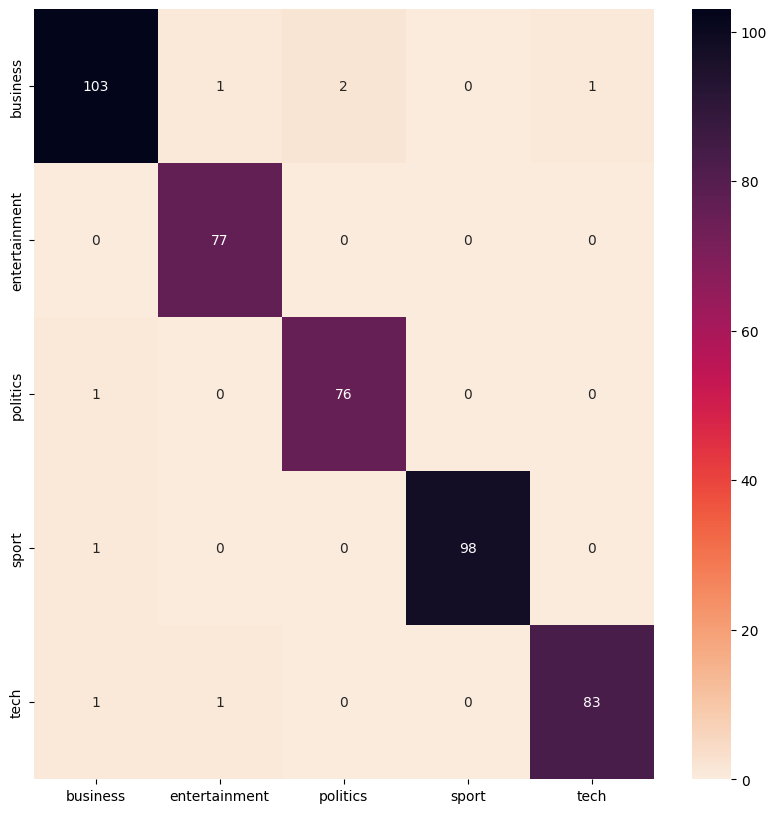

In [52]:
from sklearn import metrics 
from matplotlib import pyplot as plt
import seaborn as sns


matrix = metrics.confusion_matrix(val['label'], pred)

plt.figure(figsize=(10,10))
ax = sns.heatmap(matrix, annot=True, fmt="d", cmap = 'rocket_r', xticklabels = ['business', 'entertainment', 'politics', 'sport', 'tech']
, yticklabels = ['business', 'entertainment', 'politics', 'sport', 'tech'])

# cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix =matrix, display_labels = np.unique(val['label']))
# cm_display.plot()
# plt.show()

# Prediction example

In [95]:
# test
test_file = []
test_title = []
test_text = []

test_datapath = './archive/test_data' 
for dirname, _ , filenames in os.walk(test_datapath):    
    try:
        filenames.remove('README.TXT')
    except:
        pass
    for filename in filenames:
        test_file.append(filename)
        test_fullpathfile = os.path.join(dirname,filename)
        with open(test_fullpathfile, 'r', encoding="utf8", errors='ignore') as infile:
            intext = ''
            firstline = True
            for line in infile:
                if firstline:
                    test_title.append(line.replace('\n',''))
                    firstline = False
                else:
                    intext = intext + ' ' + line.replace('\n','')
            test_text.append(intext)


In [96]:
# test
DATA_COLUMN = 'test_text'

test_fulldf = pd.DataFrame(list(zip(test_file, test_title, test_text)), 
               columns =['file', 'title', 'text'])

test_df = test_fulldf.filter(['text'], axis=1)
# test_df.head(10)
test_fulldf.head(10)


,file,title,text
0,test2.txt,Starbucks plans to open 100 new stores across ...,It comes as the world's largest coffee chain ...
1,test.txt,World number one Novak Djokovic has withdrawn ...,"The 22-time Grand Slam winner, 35, had appli..."


In [97]:
#test
test_df.shape

(2, 1)

In [98]:
test_df.isnull().sum()

text    0
dtype: int64

In [99]:
test_df['text'] = test_df['text'].apply(clean_text)
test_df['text'] = test_df['text'].str.replace('\d+', '')
test_df.head()

/var/folders/b2/hx3hnjy967d2_x_0tbdd6xzc0000gn/T/ipykernel_1027/736500345.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  test_df['text'] = test_df['text'].str.replace('\d+', '')


,text
0,comes worlds largest coffee chain reported big...
1,time grand slam winner applied special permis...


In [100]:
test_df['text_split'] = test_df['text'].apply(get_split)
test_df.head()

,text,text_split
0,comes worlds largest coffee chain reported big...,[comes worlds largest coffee chain reported bi...
1,time grand slam winner applied special permis...,[time grand slam winner applied special permis...


In [101]:
test_l = []
test_label_l = []
test_index_l = []

for idx,row in test_df.iterrows():
    for l in row['text_split']:
        test_l.append(l)
        test_index_l.append(idx)
            
len(test_l), len(test_index_l)

(2, 2)

In [102]:
test_df = pd.DataFrame({DATA_COLUMN:test_l})
test_df.head()

,test_text
0,comes worlds largest coffee chain reported big...
1,time grand slam winner applied special permiss...


In [103]:
test_InputExamples = test_df.apply(lambda x: run_classifier.InputExample(guid=None, 
                                                                   text_a = x[DATA_COLUMN], 
                                                                   text_b = None,
                                                                   label = 0), axis = 1)

In [104]:
# print(tokenizer.vocab["##w"])

In [105]:
#Here is what the tokenised sample of the first training set observation looks like
# print(tokenizer.tokenize(test_InputExamples.iloc[0].text_a))

In [106]:
test_features = run_classifier.convert_examples_to_features(test_InputExamples, label_list, MAX_SEQ_LENGTH, tokenizer)

INFO:tensorflow:Writing example 0 of 2


INFO:tensorflow:Writing example 0 of 2


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] comes worlds largest coffee chain reported big jump sales uk continuing recovery pan ##de ##mic last year firm reportedly looking sell british operations starbucks launched uk outlets country uk expansion comes despite inflation rate prices rise near year ##hi ##gh pushing cost ingredients firm eating profits firm also plans open new stores rest europe middle east africa em ##ea however duncan moi ##r leads firms em ##ea business said remained cautious economic outlook like many businesses said starbucks faced challenges including shortages h ##g ##v drivers rising supplier costs shipping delays also struggling higher energy bills demands higher wages staff hospitality companies across uk putting pay face shortage workers cost living rises pre ##t man ##ger recently announced giving staff third pay rise months starbucks said since pan ##de ##mic customers habits changed result firm would seek increase number drive ##th ##rou ##gh branches invest digital ca

INFO:tensorflow:tokens: [CLS] comes worlds largest coffee chain reported big jump sales uk continuing recovery pan ##de ##mic last year firm reportedly looking sell british operations starbucks launched uk outlets country uk expansion comes despite inflation rate prices rise near year ##hi ##gh pushing cost ingredients firm eating profits firm also plans open new stores rest europe middle east africa em ##ea however duncan moi ##r leads firms em ##ea business said remained cautious economic outlook like many businesses said starbucks faced challenges including shortages h ##g ##v drivers rising supplier costs shipping delays also struggling higher energy bills demands higher wages staff hospitality companies across uk putting pay face shortage workers cost living rises pre ##t man ##ger recently announced giving staff third pay rise months starbucks said since pan ##de ##mic customers habits changed result firm would seek increase number drive ##th ##rou ##gh branches invest digital ca

INFO:tensorflow:input_ids: 101 3310 8484 2922 4157 4677 2988 2502 5376 4341 2866 5719 7233 6090 3207 7712 2197 2095 3813 7283 2559 5271 2329 3136 29500 3390 2866 11730 2406 2866 4935 3310 2750 14200 3446 7597 4125 2379 2095 4048 5603 6183 3465 12760 3813 5983 11372 3813 2036 3488 2330 2047 5324 2717 2885 2690 2264 3088 7861 5243 2174 7343 25175 2099 5260 9786 7861 5243 2449 2056 2815 17145 3171 17680 2066 2116 5661 2056 29500 4320 7860 2164 22623 1044 2290 2615 6853 4803 17024 5366 7829 14350 2036 8084 3020 2943 8236 7670 3020 12678 3095 15961 3316 2408 2866 5128 3477 2227 15843 3667 3465 2542 9466 3653 2102 2158 4590 3728 2623 3228 3095 2353 3477 4125 2706 29500 2056 2144 6090 3207 7712 6304 14243 2904 2765 3813 2052 6148 3623 2193 3298 2705 22494 5603 5628 15697 3617 9859 5324 2794 2116 2111 2506 2147 2188 3329 13976 23812 2103 8941 3345 3703 12430 8980 2414 6453 29500 2197 2095 7283 6195 4855 2866 2449 4320 4803 2971 8859 3813 6380 2412 2211 5337 4341 2832 2036 2718 2524 6090 3207 7

INFO:tensorflow:input_ids: 101 3310 8484 2922 4157 4677 2988 2502 5376 4341 2866 5719 7233 6090 3207 7712 2197 2095 3813 7283 2559 5271 2329 3136 29500 3390 2866 11730 2406 2866 4935 3310 2750 14200 3446 7597 4125 2379 2095 4048 5603 6183 3465 12760 3813 5983 11372 3813 2036 3488 2330 2047 5324 2717 2885 2690 2264 3088 7861 5243 2174 7343 25175 2099 5260 9786 7861 5243 2449 2056 2815 17145 3171 17680 2066 2116 5661 2056 29500 4320 7860 2164 22623 1044 2290 2615 6853 4803 17024 5366 7829 14350 2036 8084 3020 2943 8236 7670 3020 12678 3095 15961 3316 2408 2866 5128 3477 2227 15843 3667 3465 2542 9466 3653 2102 2158 4590 3728 2623 3228 3095 2353 3477 4125 2706 29500 2056 2144 6090 3207 7712 6304 14243 2904 2765 3813 2052 6148 3623 2193 3298 2705 22494 5603 5628 15697 3617 9859 5324 2794 2116 2111 2506 2147 2188 3329 13976 23812 2103 8941 3345 3703 12430 8980 2414 6453 29500 2197 2095 7283 6195 4855 2866 2449 4320 4803 2971 8859 3813 6380 2412 2211 5337 4341 2832 2036 2718 2524 6090 3207 7

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] time grand slam winner applied special permission enter us va ##cci ##nated co ##vid us requires international visitors va ##cci ##nated proof required least april dj ##oko ##vic missed last years us open va ##cci ##nation status world number one novak dj ##oko ##vic withdrawn bn ##p par ##iba ##s open withdrawal nik ##olo ##z basil ##ash ##vili moves field organise ##rs said statement indian wells one prestigious tournaments tennis calendar outside grand slams starts march friday united states tennis association us open said hopeful dj ##oko ##vic would allowed play months indian wells miami masters events dj ##oko ##vic also missed last years australian open deported country va ##cci ##nation status said would skip grand slams rather co ##vid va ##cci ##nation permitted travel melbourne january record ##ex ##ten ##ding th australian open title tying rafael nad ##als men ##s record grand slam wins [SEP]


INFO:tensorflow:tokens: [CLS] time grand slam winner applied special permission enter us va ##cci ##nated co ##vid us requires international visitors va ##cci ##nated proof required least april dj ##oko ##vic missed last years us open va ##cci ##nation status world number one novak dj ##oko ##vic withdrawn bn ##p par ##iba ##s open withdrawal nik ##olo ##z basil ##ash ##vili moves field organise ##rs said statement indian wells one prestigious tournaments tennis calendar outside grand slams starts march friday united states tennis association us open said hopeful dj ##oko ##vic would allowed play months indian wells miami masters events dj ##oko ##vic also missed last years australian open deported country va ##cci ##nation status said would skip grand slams rather co ##vid va ##cci ##nation permitted travel melbourne january record ##ex ##ten ##ding th australian open title tying rafael nad ##als men ##s record grand slam wins [SEP]


INFO:tensorflow:input_ids: 101 2051 2882 9555 3453 4162 2569 6656 4607 2149 12436 14693 23854 2522 17258 2149 5942 2248 5731 12436 14693 23854 6947 3223 2560 2258 6520 16366 7903 4771 2197 2086 2149 2330 12436 14693 9323 3570 2088 2193 2028 19580 6520 16366 7903 9633 24869 2361 11968 18410 2015 2330 10534 23205 12898 2480 14732 11823 21661 5829 2492 22933 2869 2056 4861 2796 7051 2028 8919 8504 5093 8094 2648 2882 25967 4627 2233 5958 2142 2163 5093 2523 2149 2330 2056 17772 6520 16366 7903 2052 3039 2377 2706 2796 7051 5631 5972 2824 6520 16366 7903 2036 4771 2197 2086 2827 2330 17929 2406 12436 14693 9323 3570 2056 2052 13558 2882 25967 2738 2522 17258 12436 14693 9323 7936 3604 4940 2254 2501 10288 6528 4667 16215 2827 2330 2516 15233 10999 23233 9777 2273 2015 2501 2882 9555 5222 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 2051 2882 9555 3453 4162 2569 6656 4607 2149 12436 14693 23854 2522 17258 2149 5942 2248 5731 12436 14693 23854 6947 3223 2560 2258 6520 16366 7903 4771 2197 2086 2149 2330 12436 14693 9323 3570 2088 2193 2028 19580 6520 16366 7903 9633 24869 2361 11968 18410 2015 2330 10534 23205 12898 2480 14732 11823 21661 5829 2492 22933 2869 2056 4861 2796 7051 2028 8919 8504 5093 8094 2648 2882 25967 4627 2233 5958 2142 2163 5093 2523 2149 2330 2056 17772 6520 16366 7903 2052 3039 2377 2706 2796 7051 5631 5972 2824 6520 16366 7903 2036 4771 2197 2086 2827 2330 17929 2406 12436 14693 9323 3570 2056 2052 13558 2882 25967 2738 2522 17258 12436 14693 9323 7936 3604 4940 2254 2501 10288 6528 4667 16215 2827 2330 2516 15233 10999 23233 9777 2273 2015 2501 2882 9555 5222 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


In [107]:
test_input_fn = run_classifier.input_fn_builder(
    features=test_features,
    seq_length=MAX_SEQ_LENGTH,
    is_training=False,
    drop_remainder=False)

In [108]:
test_out=estimator.predict(input_fn=test_input_fn, yield_single_examples=False)

In [109]:
predic_result = next(test_out)
print(predic_result)
c=np.argmax(predic_result['probabilities'], axis=1)
le.inverse_transform(c)

INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.
2023-03-12 16:01:23.859439: W tensorflow/core/common_runtime/graph_constructor.cc:1526] Importing a graph with a lower producer version 27 into an existing graph with producer version 1087. Shape inference will have run different parts of the graph with different producer versions.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from ./bert_news_category/model.ckpt-111


2023-03-12 16:01:25.287249: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-03-12 16:01:25.287297: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
INFO:tensorflow:Restoring parameters from ./bert_news_category/model.ckpt-111
2023-03-12 16:01:25.389385: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Running local_init_op.


2023-03-12 16:01:25.967930: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


2023-03-12 16:01:26.018794: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
INFO:tensorflow:Done running local_init_op.
2023-03-12 16:01:26.037923: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-03-12 16:01:26.100851: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-03-12 16:01:26.125487: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


{'probabilities': array([[-0.01260737, -5.5149946 , -5.8220215 , -5.795988  , -5.991052  ],
       [-6.113459  , -6.3974442 , -6.67604   , -0.00814496, -5.818375  ]],
      dtype=float32), 'labels': array([0, 3], dtype=int32), 'pooled_output': array([[ 0.35187992,  0.7716934 ,  0.9999582 , ...,  0.99605316,
         0.4443725 , -0.05939209],
       [ 0.5740807 , -0.20175342,  0.26008132, ..., -0.7837786 ,
         0.03119677,  0.68072635]], dtype=float32)}


array(['business', 'sport'], dtype=object)

# Validation with CNN dataset

In [209]:
DATA_COLUMN = 'text'
LABEL_COLUMN = 'label'
fileDirectory= './archive/CNN_Articels_clean/CNN_Articels_clean.csv'

test= pd.read_csv (fileDirectory, usecols=['Article text', 'Category'])
test.rename(columns={'Article text': 'text', 'Category': 'label'}, inplace = True)
test.head(10)

,label,text
0,news,"(CNN)Right now, there's a shortage of truck d..."
1,news,(CNN)Working in a factory or warehouse can me...
2,news,"(CNN)In a Hong Kong warehouse, a swarm of aut..."
3,business,"New York (CNN Business)For many years, the wor..."
4,business,The European Union formally approved on Tuesda...
5,business,(CNN Business)A woman holding a sign reading ...
6,business,New York (CNN Business)Fox News correspondent ...
7,business,London (CNN Business)Russia has sent the clear...
8,business,New York (CNN Business)US oil prices briefly t...
9,business,New DelhiIndia may take up a Russian offer to ...


In [210]:
for label in np.unique(test['label']):
    print(label)

business
entertainment
health
news
politics
sport


In [211]:
test = test.query("label=='sport' | label=='politics' | label=='entertainment' | label=='business' | label=='tech' ")
test.reset_index(drop=True, inplace=True)
test

,label,text
0,business,"New York (CNN Business)For many years, the wor..."
1,business,The European Union formally approved on Tuesda...
2,business,(CNN Business)A woman holding a sign reading ...
3,business,New York (CNN Business)Fox News correspondent ...
4,business,London (CNN Business)Russia has sent the clear...
...,...,...
2408,sport,(CNN)French side Troyes has alleged that Sout...
2409,sport,(Reuters)The Australian Open's Covid-19 vacci...
2410,sport,(CNN)Four golfers scheduled to play in the So...
2411,sport,(CNN)Long-time International Olympic Committe...


<Axes: >

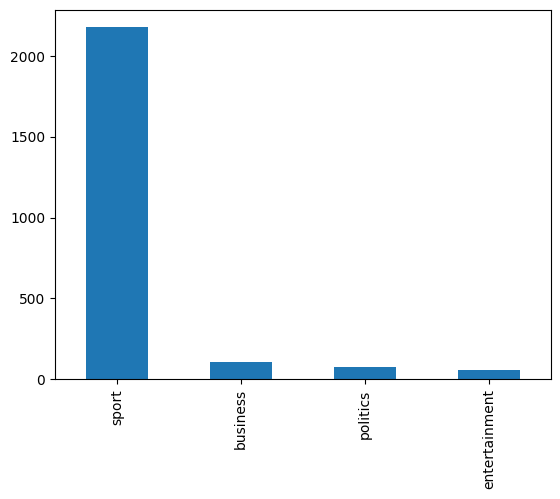

In [212]:
# Checking number of records of each label
test['label'].value_counts().plot(kind='bar')

<Axes: >

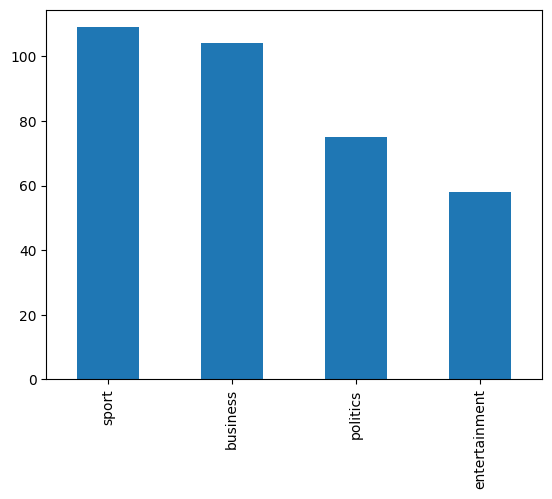

In [213]:
test.drop(test[(test['label'] == 'sport')].sample(frac=0.95).index, inplace=True)
test['label'].value_counts().plot(kind='bar')

In [214]:
test.reset_index(drop=True, inplace=True)

In [215]:
for label in np.unique(test['label']):
    print(label)

business
entertainment
politics
sport


In [216]:
test.shape

(346, 2)

In [217]:
test.isnull().sum()

label    0
text     0
dtype: int64

In [218]:
le = LabelEncoder()
test['label'] = le.fit_transform(test['label'])
list(le.classes_)

['business', 'entertainment', 'politics', 'sport']

In [219]:
# Removing (CNN) and (CNN Business)
# texts of (CNN Business) are bestill beginns with a city name!!

test['text_clean'] = test['text'].str.replace('(CNN Business)', '')
test['text_clean'] = test['text_clean'].str.replace('(CNN)', '')

test['text_clean'] = test['text_clean'].apply(clean_text)
test['text_clean'] = test['text_clean'].str.replace('\d+', '')
test

/var/folders/b2/hx3hnjy967d2_x_0tbdd6xzc0000gn/T/ipykernel_1027/1937921843.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  test['text_clean'] = test['text'].str.replace('(CNN Business)', '')
/var/folders/b2/hx3hnjy967d2_x_0tbdd6xzc0000gn/T/ipykernel_1027/1937921843.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  test['text_clean'] = test['text_clean'].str.replace('(CNN)', '')
/var/folders/b2/hx3hnjy967d2_x_0tbdd6xzc0000gn/T/ipykernel_1027/1937921843.py:8: FutureWarning: The default value of regex will change from True to False in a future version.
  test['text_clean'] = test['text_clean'].str.replace('\d+', '')


,label,text,text_clean
0,0,"New York (CNN Business)For many years, the wor...",new york many years worlds popular emerging ma...
1,0,The European Union formally approved on Tuesda...,european union formally approved tuesday new b...
2,0,(CNN Business)A woman holding a sign reading ...,woman holding sign reading war interrupted liv...
3,0,New York (CNN Business)Fox News correspondent ...,new york fox news correspondent benjamin hall ...
4,0,London (CNN Business)Russia has sent the clear...,london russia sent clearest signal yet soon de...
...,...,...,...
341,3,"(CNN)The Alabama Crimson Tide, Michigan Wolve...",alabama crimson tide michigan wolverines georg...
342,3,(CNN)Longtime Atlanta Falcons defensive end a...,longtime atlanta falcons defensive end pro foo...
343,3,"(CNN)First-team coach Andrew Gale, Director o...",firstteam coach andrew gale director cricket m...
344,3,(CNN)The collective bargaining agreement betw...,collective bargaining agreement major league b...


In [220]:
test['text_split'] = test['text_clean'].apply(get_split)
test

,label,text,text_clean,text_split
0,0,"New York (CNN Business)For many years, the wor...",new york many years worlds popular emerging ma...,[new york many years worlds popular emerging m...
1,0,The European Union formally approved on Tuesda...,european union formally approved tuesday new b...,[european union formally approved tuesday new ...
2,0,(CNN Business)A woman holding a sign reading ...,woman holding sign reading war interrupted liv...,[woman holding sign reading war interrupted li...
3,0,New York (CNN Business)Fox News correspondent ...,new york fox news correspondent benjamin hall ...,[new york fox news correspondent benjamin hall...
4,0,London (CNN Business)Russia has sent the clear...,london russia sent clearest signal yet soon de...,[london russia sent clearest signal yet soon d...
...,...,...,...,...
341,3,"(CNN)The Alabama Crimson Tide, Michigan Wolve...",alabama crimson tide michigan wolverines georg...,[alabama crimson tide michigan wolverines geor...
342,3,(CNN)Longtime Atlanta Falcons defensive end a...,longtime atlanta falcons defensive end pro foo...,[longtime atlanta falcons defensive end pro fo...
343,3,"(CNN)First-team coach Andrew Gale, Director o...",firstteam coach andrew gale director cricket m...,[firstteam coach andrew gale director cricket ...
344,3,(CNN)The collective bargaining agreement betw...,collective bargaining agreement major league b...,[collective bargaining agreement major league ...


In [221]:
test['num_text_split'] = test['text_split'].apply(lambda x: len(x))
n=max(test['num_text_split'])
print(n)
test

26


,label,text,text_clean,text_split,num_text_split
0,0,"New York (CNN Business)For many years, the wor...",new york many years worlds popular emerging ma...,[new york many years worlds popular emerging m...,2
1,0,The European Union formally approved on Tuesda...,european union formally approved tuesday new b...,[european union formally approved tuesday new ...,2
2,0,(CNN Business)A woman holding a sign reading ...,woman holding sign reading war interrupted liv...,[woman holding sign reading war interrupted li...,2
3,0,New York (CNN Business)Fox News correspondent ...,new york fox news correspondent benjamin hall ...,[new york fox news correspondent benjamin hall...,1
4,0,London (CNN Business)Russia has sent the clear...,london russia sent clearest signal yet soon de...,[london russia sent clearest signal yet soon d...,2
...,...,...,...,...,...
341,3,"(CNN)The Alabama Crimson Tide, Michigan Wolve...",alabama crimson tide michigan wolverines georg...,[alabama crimson tide michigan wolverines geor...,1
342,3,(CNN)Longtime Atlanta Falcons defensive end a...,longtime atlanta falcons defensive end pro foo...,[longtime atlanta falcons defensive end pro fo...,1
343,3,"(CNN)First-team coach Andrew Gale, Director o...",firstteam coach andrew gale director cricket m...,[firstteam coach andrew gale director cricket ...,1
344,3,(CNN)The collective bargaining agreement betw...,collective bargaining agreement major league b...,[collective bargaining agreement major league ...,1


In [222]:
l_num=0
h=0
j=0
m=0
r=0
s=0
 
s=test['num_text_split'].sum()

for idx,row in test.iterrows():
    j=j+len(row['text_split'])
   
    
#N. of rows with more than one element in text_split
    if len(row['text_split'])>1:
        h=h+1
#         print(len(row['text_split'][0].split()))
#         print(idx,row['num_text_split'],len(row['text_split']),'\n')
        
#N. of rows with more than 150 words in text_clean
    if len(row['text_clean'].split())>150:
        m=m+1
#         print(len(row['text_clean']))
#N. of rows with more than 150 words in text
    if len(row['text'].split())>=150:
        r=r+1
        
    for l in row['text_split']:        
        l_num = l_num+1
        
print(s, j, h, m, r, l_num)

1061 1061 224 320 344 1061


In [223]:
test_l = []
test_label_l = []
test_index_l = []

for idx,row in test.iterrows():
    for l in row['text_split']:
        test_l.append(l)
        test_label_l.append(row['label'])
        test_index_l.append(idx)
            
len(test_l), len(test_index_l) , len(test_label_l)

(1061, 1061, 1061)

In [224]:
test_df = pd.DataFrame({DATA_COLUMN:test_l, LABEL_COLUMN:test_label_l})
test_df

,text,label
0,new york many years worlds popular emerging ma...,0
1,based acronym winograd said always strange say...,0
2,european union formally approved tuesday new b...,0
3,banned eu sources saidthe package also prohibi...,0
4,woman holding sign reading war interrupted liv...,0
...,...,...
1056,alabama crimson tide michigan wolverines georg...,3
1057,longtime atlanta falcons defensive end pro foo...,3
1058,firstteam coach andrew gale director cricket m...,3
1059,collective bargaining agreement major league b...,3


In [84]:
test_df.shape

(1064, 2)

In [85]:
test_InputExamples = test_df.apply(lambda x: run_classifier.InputExample(guid=None, 
                                                                   text_a = x[DATA_COLUMN], 
                                                                   text_b = None, 
                                                                   label = x[LABEL_COLUMN]), axis = 1)

In [86]:
#Here is what the tokenised sample of the first training set observation looks like
print(tokenizer.tokenize(test_InputExamples.iloc[0].text_a))

['new', 'york', 'many', 'years', 'worlds', 'popular', 'emerging', 'markets', 'soc', '##alle', '##d', 'br', '##ics', 'brazil', 'russia', 'india', 'china', 'south', 'africa', '##bu', '##t', 'given', 'russia', 'longer', 'market', 'western', '##ers', 'access', 'following', 'invasion', 'ukraine', 'might', 'time', 'investors', 'stop', 'lump', '##ing', 'emerging', 'markets', 'together', '##the', 'br', '##ics', 'day', 'sun', 'faded', 'said', 'eric', 'win', '##og', '##rad', 'senior', 'economist', 'alliance', '##ber', '##nstein', '##se', '##vera', '##l', 'major', 'us', 'index', 'providers', 'removed', 'russian', 'stocks', 'index', '##es', 'price', 'zero', 'effectively', 'zero', 'trading', 'shares', 'several', 'leading', 'usl', '##iste', '##d', 'russian', 'companies', 'search', 'engine', 'yan', '##de', '##x', 'telecom', 'mt', '##s', 'halted', 'moscow', 'stock', 'exchange', 'closed', 'since', 'february', 'day', 'invasion', '##rus', '##sia', 'could', 'default', 'debt', 'within', 'days', '##the', 'i

In [87]:
test_features = run_classifier.convert_examples_to_features(test_InputExamples, label_list, MAX_SEQ_LENGTH, tokenizer)

INFO:tensorflow:Writing example 0 of 1064


INFO:tensorflow:Writing example 0 of 1064


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] new york many years worlds popular emerging markets soc ##alle ##d br ##ics brazil russia india china south africa ##bu ##t given russia longer market western ##ers access following invasion ukraine might time investors stop lump ##ing emerging markets together ##the br ##ics day sun faded said eric win ##og ##rad senior economist alliance ##ber ##nstein ##se ##vera ##l major us index providers removed russian stocks index ##es price zero effectively zero trading shares several leading usl ##iste ##d russian companies search engine yan ##de ##x telecom mt ##s halted moscow stock exchange closed since february day invasion ##rus ##sia could default debt within days ##the idea country large russia removed index ##es big deal win ##og ##rad said ##rea ##d more ##it seems likely russia included top emerging markets funds anytime soon even western ##ers still willing invest russian assets clear comes next ##some investors asking exposure russia emerging markets

INFO:tensorflow:tokens: [CLS] new york many years worlds popular emerging markets soc ##alle ##d br ##ics brazil russia india china south africa ##bu ##t given russia longer market western ##ers access following invasion ukraine might time investors stop lump ##ing emerging markets together ##the br ##ics day sun faded said eric win ##og ##rad senior economist alliance ##ber ##nstein ##se ##vera ##l major us index providers removed russian stocks index ##es price zero effectively zero trading shares several leading usl ##iste ##d russian companies search engine yan ##de ##x telecom mt ##s halted moscow stock exchange closed since february day invasion ##rus ##sia could default debt within days ##the idea country large russia removed index ##es big deal win ##og ##rad said ##rea ##d more ##it seems likely russia included top emerging markets funds anytime soon even western ##ers still willing invest russian assets clear comes next ##some investors asking exposure russia emerging markets

INFO:tensorflow:input_ids: 101 2047 2259 2116 2086 8484 2759 8361 6089 27084 24164 2094 7987 6558 4380 3607 2634 2859 2148 3088 8569 2102 2445 3607 2936 3006 2530 2545 3229 2206 5274 5924 2453 2051 9387 2644 15116 2075 8361 6089 2362 10760 7987 6558 2154 3103 8105 2056 4388 2663 8649 12173 3026 11708 4707 5677 15493 3366 26061 2140 2350 2149 5950 11670 3718 2845 15768 5950 2229 3976 5717 6464 5717 6202 6661 2195 2877 22448 27870 2094 2845 3316 3945 3194 13619 3207 2595 18126 11047 2015 12705 4924 4518 3863 2701 2144 2337 2154 5274 7946 8464 2071 12398 7016 2306 2420 10760 2801 2406 2312 3607 3718 5950 2229 2502 3066 2663 8649 12173 2056 16416 2094 2062 4183 3849 3497 3607 2443 2327 8361 6089 5029 15933 2574 2130 2530 2545 2145 5627 15697 2845 7045 3154 3310 2279 14045 9387 4851 7524 3607 8361 6089 5029 5950 2229 3225 23329 3607 2145 3524 29560 4402 2208 2056 2026 18598 26925 2132 19920 2488 3672 29278 9387 2559 2131 7524 8361 6089 2663 8649 12173 2056 2406 2246 14258 10760 2171 2208 20

INFO:tensorflow:input_ids: 101 2047 2259 2116 2086 8484 2759 8361 6089 27084 24164 2094 7987 6558 4380 3607 2634 2859 2148 3088 8569 2102 2445 3607 2936 3006 2530 2545 3229 2206 5274 5924 2453 2051 9387 2644 15116 2075 8361 6089 2362 10760 7987 6558 2154 3103 8105 2056 4388 2663 8649 12173 3026 11708 4707 5677 15493 3366 26061 2140 2350 2149 5950 11670 3718 2845 15768 5950 2229 3976 5717 6464 5717 6202 6661 2195 2877 22448 27870 2094 2845 3316 3945 3194 13619 3207 2595 18126 11047 2015 12705 4924 4518 3863 2701 2144 2337 2154 5274 7946 8464 2071 12398 7016 2306 2420 10760 2801 2406 2312 3607 3718 5950 2229 2502 3066 2663 8649 12173 2056 16416 2094 2062 4183 3849 3497 3607 2443 2327 8361 6089 5029 15933 2574 2130 2530 2545 2145 5627 15697 2845 7045 3154 3310 2279 14045 9387 4851 7524 3607 8361 6089 5029 5950 2229 3225 23329 3607 2145 3524 29560 4402 2208 2056 2026 18598 26925 2132 19920 2488 3672 29278 9387 2559 2131 7524 8361 6089 2663 8649 12173 2056 2406 2246 14258 10760 2171 2208 20

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] based acronym win ##og ##rad said always strange say argentina south korea thing example they ##re forget br ##ics look tick ##s mist ##to stick acronym ##s shut ##down russian stock market essentially turned br ##ics bi ##cs could permanent change said ra ##hul sen sharma managing partner ind ##xx global index provider investors ever embrace russia liquid ##ity mo ##ot point also hard believe people rush russia anytime soon sen sharma told sen sharma said investors may start look emerging markets replace russia taiwan south korea br ##ics could become tick ##s added poland turkey mexico intriguing philippines indonesia could dub mexico indonesia south korea turkey mist markets people love acronym ##s sen sharma joked ##of course emerging market europe think poland inherently risky close geographically russia ukraine central eastern european nations may hard sell western investors ##war ukraine sparked scramble dollars ##oth ##er experts argue investors lo

INFO:tensorflow:tokens: [CLS] based acronym win ##og ##rad said always strange say argentina south korea thing example they ##re forget br ##ics look tick ##s mist ##to stick acronym ##s shut ##down russian stock market essentially turned br ##ics bi ##cs could permanent change said ra ##hul sen sharma managing partner ind ##xx global index provider investors ever embrace russia liquid ##ity mo ##ot point also hard believe people rush russia anytime soon sen sharma told sen sharma said investors may start look emerging markets replace russia taiwan south korea br ##ics could become tick ##s added poland turkey mexico intriguing philippines indonesia could dub mexico indonesia south korea turkey mist markets people love acronym ##s sen sharma joked ##of course emerging market europe think poland inherently risky close geographically russia ukraine central eastern european nations may hard sell western investors ##war ukraine sparked scramble dollars ##oth ##er experts argue investors lo

INFO:tensorflow:input_ids: 101 2241 20137 2663 8649 12173 2056 2467 4326 2360 5619 2148 4420 2518 2742 2027 2890 5293 7987 6558 2298 16356 2015 11094 3406 6293 20137 2015 3844 7698 2845 4518 3006 7687 2357 7987 6558 12170 6169 2071 4568 2689 2056 10958 21886 12411 14654 6605 4256 27427 20348 3795 5950 10802 9387 2412 9979 3607 6381 3012 9587 4140 2391 2036 2524 2903 2111 5481 3607 15933 2574 12411 14654 2409 12411 14654 2056 9387 2089 2707 2298 8361 6089 5672 3607 6629 2148 4420 7987 6558 2071 2468 16356 2015 2794 3735 4977 3290 23824 5137 6239 2071 12931 3290 6239 2148 4420 4977 11094 6089 2111 2293 20137 2015 12411 14654 19700 11253 2607 8361 3006 2885 2228 3735 26096 19188 2485 20969 3607 5924 2430 2789 2647 3741 2089 2524 5271 2530 9387 9028 5924 13977 25740 6363 14573 2121 8519 7475 9387 2559 3265 3316 8361 6089 2625 3032 3209 2050 5171 14316 5927 8361 6089 2465 15768 3538 11103 2056 20072 9574 2149 5211 12941 3802 14604 10760 8361 6089 5957 5278 19511 9574 2794 9073 2116 9387 183

INFO:tensorflow:input_ids: 101 2241 20137 2663 8649 12173 2056 2467 4326 2360 5619 2148 4420 2518 2742 2027 2890 5293 7987 6558 2298 16356 2015 11094 3406 6293 20137 2015 3844 7698 2845 4518 3006 7687 2357 7987 6558 12170 6169 2071 4568 2689 2056 10958 21886 12411 14654 6605 4256 27427 20348 3795 5950 10802 9387 2412 9979 3607 6381 3012 9587 4140 2391 2036 2524 2903 2111 5481 3607 15933 2574 12411 14654 2409 12411 14654 2056 9387 2089 2707 2298 8361 6089 5672 3607 6629 2148 4420 7987 6558 2071 2468 16356 2015 2794 3735 4977 3290 23824 5137 6239 2071 12931 3290 6239 2148 4420 4977 11094 6089 2111 2293 20137 2015 12411 14654 19700 11253 2607 8361 3006 2885 2228 3735 26096 19188 2485 20969 3607 5924 2430 2789 2647 3741 2089 2524 5271 2530 9387 9028 5924 13977 25740 6363 14573 2121 8519 7475 9387 2559 3265 3316 8361 6089 2625 3032 3209 2050 5171 14316 5927 8361 6089 2465 15768 3538 11103 2056 20072 9574 2149 5211 12941 3802 14604 10760 8361 6089 5957 5278 19511 9574 2794 9073 2116 9387 183

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] european union formally approved tuesday new barrage sanctions russia invasion ukraine include ban ##s investments russian energy sector luxury goods exports imports steel products russia ##the sanctions come effect publication eu official journal later tuesday also freeze assets business leaders support russian state including chelsea football club owner roman ab ##ram ##ovich european commission said statement tuesday sanctions included far ##rea ##ching ban new investment across russian energy sector limited exceptions civil nuclear energy transport certain energy products back eu ##the measure hit russia ##s oil majors ro ##s ##ne ##ft trans ##ne ##ft ga ##z ##pro ##m ne ##ft g ##z ##pf ##y eu members still able buy oil gas eu source told reuters ##ther ##e also total ban transactions russian state ##own ##ed enterprises linked k ##rem ##lins military ##ind ##ust ##rial complex eu executive said ##rea ##d more ##the bloc reached preliminary agreement n

INFO:tensorflow:tokens: [CLS] european union formally approved tuesday new barrage sanctions russia invasion ukraine include ban ##s investments russian energy sector luxury goods exports imports steel products russia ##the sanctions come effect publication eu official journal later tuesday also freeze assets business leaders support russian state including chelsea football club owner roman ab ##ram ##ovich european commission said statement tuesday sanctions included far ##rea ##ching ban new investment across russian energy sector limited exceptions civil nuclear energy transport certain energy products back eu ##the measure hit russia ##s oil majors ro ##s ##ne ##ft trans ##ne ##ft ga ##z ##pro ##m ne ##ft g ##z ##pf ##y eu members still able buy oil gas eu source told reuters ##ther ##e also total ban transactions russian state ##own ##ed enterprises linked k ##rem ##lins military ##ind ##ust ##rial complex eu executive said ##rea ##d more ##the bloc reached preliminary agreement n

INFO:tensorflow:input_ids: 101 2647 2586 6246 4844 9857 2047 19359 17147 3607 5274 5924 2421 7221 2015 10518 2845 2943 4753 9542 5350 14338 17589 3886 3688 3607 10760 17147 2272 3466 4772 7327 2880 3485 2101 9857 2036 13184 7045 2449 4177 2490 2845 2110 2164 9295 2374 2252 3954 3142 11113 6444 12303 2647 3222 2056 4861 9857 17147 2443 2521 16416 8450 7221 2047 5211 2408 2845 2943 4753 3132 11790 2942 4517 2943 3665 3056 2943 3688 2067 7327 10760 5468 2718 3607 2015 3514 15279 20996 2015 2638 6199 9099 2638 6199 11721 2480 21572 2213 11265 6199 1043 2480 14376 2100 7327 2372 2145 2583 4965 3514 3806 7327 3120 2409 26665 12399 2063 2036 2561 7221 11817 2845 2110 12384 2098 9926 5799 1047 28578 24412 2510 22254 19966 14482 3375 7327 3237 2056 16416 2094 2062 10760 15984 2584 8824 3820 2047 17147 6928 17304 2992 3530 15117 10760 7221 2845 3886 17589 4358 7461 4551 19329 4551 4276 3688 3222 2056 13765 3316 2036 2936 3039 9167 9542 5350 4276 19329 2164 11912 14338 3765 22173 19329 2036 7917 

INFO:tensorflow:input_ids: 101 2647 2586 6246 4844 9857 2047 19359 17147 3607 5274 5924 2421 7221 2015 10518 2845 2943 4753 9542 5350 14338 17589 3886 3688 3607 10760 17147 2272 3466 4772 7327 2880 3485 2101 9857 2036 13184 7045 2449 4177 2490 2845 2110 2164 9295 2374 2252 3954 3142 11113 6444 12303 2647 3222 2056 4861 9857 17147 2443 2521 16416 8450 7221 2047 5211 2408 2845 2943 4753 3132 11790 2942 4517 2943 3665 3056 2943 3688 2067 7327 10760 5468 2718 3607 2015 3514 15279 20996 2015 2638 6199 9099 2638 6199 11721 2480 21572 2213 11265 6199 1043 2480 14376 2100 7327 2372 2145 2583 4965 3514 3806 7327 3120 2409 26665 12399 2063 2036 2561 7221 11817 2845 2110 12384 2098 9926 5799 1047 28578 24412 2510 22254 19966 14482 3375 7327 3237 2056 16416 2094 2062 10760 15984 2584 8824 3820 2047 17147 6928 17304 2992 3530 15117 10760 7221 2845 3886 17589 4358 7461 4551 19329 4551 4276 3688 3222 2056 13765 3316 2036 2936 3039 9167 9542 5350 4276 19329 2164 11912 14338 3765 22173 19329 2036 7917 

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] banned eu sources said ##the package also prohibits eu credit rating agencies issuing ratings russia russian companies commission says restrict access european financial markets ##the latest sanctions follow three rounds pun ##itive measures included freezing assets russian central bank exclusion swift banking system russian belarusian banks ##the eu also agreed tuesday strip russia most ##fa ##vor ##ed nation trade status opening door pun ##itive tariffs russian goods outright import ban ##su ##k slap ##s tariff russian vodka ##the uk government also announced fresh round sanctions russia tuesday ban export luxury goods russia introduce tariffs russian goods worth billion additional tariff applied imports including vodka steel works art fur united kingdom also deny russia belarus access favoured nation trading tariff hundreds exports effectively de ##pr ##iving countries key benefits w ##to membership ##our new tariffs isolate russian economy global trade

INFO:tensorflow:tokens: [CLS] banned eu sources said ##the package also prohibits eu credit rating agencies issuing ratings russia russian companies commission says restrict access european financial markets ##the latest sanctions follow three rounds pun ##itive measures included freezing assets russian central bank exclusion swift banking system russian belarusian banks ##the eu also agreed tuesday strip russia most ##fa ##vor ##ed nation trade status opening door pun ##itive tariffs russian goods outright import ban ##su ##k slap ##s tariff russian vodka ##the uk government also announced fresh round sanctions russia tuesday ban export luxury goods russia introduce tariffs russian goods worth billion additional tariff applied imports including vodka steel works art fur united kingdom also deny russia belarus access favoured nation trading tariff hundreds exports effectively de ##pr ##iving countries key benefits w ##to membership ##our new tariffs isolate russian economy global trade

INFO:tensorflow:input_ids: 101 7917 7327 4216 2056 10760 7427 2036 25822 7327 4923 5790 6736 15089 8599 3607 2845 3316 3222 2758 21573 3229 2647 3361 6089 10760 6745 17147 3582 2093 6241 26136 13043 5761 2443 12809 7045 2845 2430 2924 15945 9170 8169 2291 2845 15626 5085 10760 7327 2036 3530 9857 6167 3607 2087 7011 14550 2098 3842 3119 3570 3098 2341 26136 13043 26269 2845 5350 13848 12324 7221 6342 2243 14308 2015 23234 2845 21092 10760 2866 2231 2036 2623 4840 2461 17147 3607 9857 7221 9167 9542 5350 3607 8970 26269 2845 5350 4276 4551 3176 23234 4162 17589 2164 21092 3886 2573 2396 6519 2142 2983 2036 9772 3607 12545 3229 16822 3842 6202 23234 5606 14338 6464 2139 18098 14966 3032 3145 6666 1059 3406 5779 8162 2047 26269 27152 2845 4610 3795 3119 12725 5770 3513 15058 2094 2248 2291 4847 26269 3857 2866 2015 4493 2147 2732 3726 3607 2015 3229 2248 5446 2624 7542 22072 2015 13675 10698 2229 4654 8743 4555 3171 3778 6939 5446 2704 15544 6182 3103 4817 2056 4861 6487 2167 5201 3720 10

INFO:tensorflow:input_ids: 101 7917 7327 4216 2056 10760 7427 2036 25822 7327 4923 5790 6736 15089 8599 3607 2845 3316 3222 2758 21573 3229 2647 3361 6089 10760 6745 17147 3582 2093 6241 26136 13043 5761 2443 12809 7045 2845 2430 2924 15945 9170 8169 2291 2845 15626 5085 10760 7327 2036 3530 9857 6167 3607 2087 7011 14550 2098 3842 3119 3570 3098 2341 26136 13043 26269 2845 5350 13848 12324 7221 6342 2243 14308 2015 23234 2845 21092 10760 2866 2231 2036 2623 4840 2461 17147 3607 9857 7221 9167 9542 5350 3607 8970 26269 2845 5350 4276 4551 3176 23234 4162 17589 2164 21092 3886 2573 2396 6519 2142 2983 2036 9772 3607 12545 3229 16822 3842 6202 23234 5606 14338 6464 2139 18098 14966 3032 3145 6666 1059 3406 5779 8162 2047 26269 27152 2845 4610 3795 3119 12725 5770 3513 15058 2094 2248 2291 4847 26269 3857 2866 2015 4493 2147 2732 3726 3607 2015 3229 2248 5446 2624 7542 22072 2015 13675 10698 2229 4654 8743 4555 3171 3778 6939 5446 2704 15544 6182 3103 4817 2056 4861 6487 2167 5201 3720 10

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] woman holding sign reading war interrupted live news broadcast russian state television monday den ##oun ##ce russia ##s invasion ukraine stop war believe propaganda tell lies sign reads russians war last line sign says english ##the woman carried bold act defiance identified maria o ##vs ##yan ##nikov ##a employee russia channel one according o ##vd ##in ##fo independent human rights protest ##mon ##itor ##ing group outlets content tightly controlled russian government ##chin ##a expressed open ##ness providing military financial aid russia us cable suggests cannot independently verify woman holding sign o ##vs ##yan ##nikov ##a photos social media profiles bearing name match woman seen screen ##rus ##sian state news agency ta ##ss confirmed o ##vd ##in ##fo ##s reporting citing source added could face prosecution ##rea ##d more ##fr ##ien ##ds o ##vs ##yan ##nikov ##a told o ##vd ##in ##fo os ##tan ##kin ##o police department moscow lawyer dmitry za ##kh

INFO:tensorflow:tokens: [CLS] woman holding sign reading war interrupted live news broadcast russian state television monday den ##oun ##ce russia ##s invasion ukraine stop war believe propaganda tell lies sign reads russians war last line sign says english ##the woman carried bold act defiance identified maria o ##vs ##yan ##nikov ##a employee russia channel one according o ##vd ##in ##fo independent human rights protest ##mon ##itor ##ing group outlets content tightly controlled russian government ##chin ##a expressed open ##ness providing military financial aid russia us cable suggests cannot independently verify woman holding sign o ##vs ##yan ##nikov ##a photos social media profiles bearing name match woman seen screen ##rus ##sian state news agency ta ##ss confirmed o ##vd ##in ##fo ##s reporting citing source added could face prosecution ##rea ##d more ##fr ##ien ##ds o ##vs ##yan ##nikov ##a told o ##vd ##in ##fo os ##tan ##kin ##o police department moscow lawyer dmitry za ##kh

INFO:tensorflow:input_ids: 101 2450 3173 3696 3752 2162 7153 2444 2739 3743 2845 2110 2547 6928 7939 23709 3401 3607 2015 5274 5924 2644 2162 2903 10398 2425 3658 3696 9631 12513 2162 2197 2240 3696 2758 2394 10760 2450 3344 7782 2552 19674 4453 3814 1051 15088 7054 22576 2050 7904 3607 3149 2028 2429 1051 16872 2378 14876 2981 2529 2916 6186 8202 15660 2075 2177 11730 4180 7371 4758 2845 2231 17231 2050 5228 2330 2791 4346 2510 3361 4681 3607 2149 5830 6083 3685 9174 20410 2450 3173 3696 1051 15088 7054 22576 2050 7760 2591 2865 17879 7682 2171 2674 2450 2464 3898 7946 17043 2110 2739 4034 11937 4757 4484 1051 16872 2378 14876 2015 7316 8951 3120 2794 2071 2227 11537 16416 2094 2062 19699 9013 5104 1051 15088 7054 22576 2050 2409 1051 16872 2378 14876 9808 5794 4939 2080 2610 2533 4924 5160 22141 23564 10023 22879 4492 2101 2409 2481 2102 12453 2134 2102 2424 5719 3945 23564 10023 22879 4492 2056 10760 2552 6186 2234 3053 2093 3134 3607 10836 8581 5924 4292 11470 7071 2406 29170 4602 

INFO:tensorflow:input_ids: 101 2450 3173 3696 3752 2162 7153 2444 2739 3743 2845 2110 2547 6928 7939 23709 3401 3607 2015 5274 5924 2644 2162 2903 10398 2425 3658 3696 9631 12513 2162 2197 2240 3696 2758 2394 10760 2450 3344 7782 2552 19674 4453 3814 1051 15088 7054 22576 2050 7904 3607 3149 2028 2429 1051 16872 2378 14876 2981 2529 2916 6186 8202 15660 2075 2177 11730 4180 7371 4758 2845 2231 17231 2050 5228 2330 2791 4346 2510 3361 4681 3607 2149 5830 6083 3685 9174 20410 2450 3173 3696 1051 15088 7054 22576 2050 7760 2591 2865 17879 7682 2171 2674 2450 2464 3898 7946 17043 2110 2739 4034 11937 4757 4484 1051 16872 2378 14876 2015 7316 8951 3120 2794 2071 2227 11537 16416 2094 2062 19699 9013 5104 1051 15088 7054 22576 2050 2409 1051 16872 2378 14876 9808 5794 4939 2080 2610 2533 4924 5160 22141 23564 10023 22879 4492 2101 2409 2481 2102 12453 2134 2102 2424 5719 3945 23564 10023 22879 4492 2056 10760 2552 6186 2234 3053 2093 3134 3607 10836 8581 5924 4292 11470 7071 2406 29170 4602 

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


In [88]:
test_input_fn = run_classifier.input_fn_builder(
    features=test_features,
    seq_length=MAX_SEQ_LENGTH,
    is_training=False,
    drop_remainder=False)

In [89]:
test_InputExamples.shape

(1064,)

In [90]:
# test_out=estimator.predict(input_fn=test_input_fn, yield_single_examples=False)

In [91]:
test_pred = []
test_out=estimator.predict(input_fn=test_input_fn, yield_single_examples=False)
while(True):
    try:
        test_bash_pred=next(test_out)['labels']
        print(bash_pred)
        test_pred = np.concatenate([test_pred, test_bash_pred])
    except:
        break


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.
2023-03-12 15:15:18.547800: W tensorflow/core/common_runtime/graph_constructor.cc:1526] Importing a graph with a lower producer version 27 into an existing graph with producer version 1087. Shape inference will have run different parts of the graph with different producer versions.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from ./bert_news_category/model.ckpt-111


2023-03-12 15:15:19.911561: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-03-12 15:15:19.911591: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
INFO:tensorflow:Restoring parameters from ./bert_news_category/model.ckpt-111
2023-03-12 15:15:19.985549: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Running local_init_op.


2023-03-12 15:15:20.463099: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


2023-03-12 15:15:20.516283: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
INFO:tensorflow:Done running local_init_op.
2023-03-12 15:15:20.531357: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-03-12 15:15:20.589685: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-03-12 15:15:20.609362: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[4 0 3 3 2 2 4 1 1 1 1 3 0]
[4 0 3 3 2 2 4 1 1 1 1 3 0]
[4 0 3 3 2 2 4 1 1 1 1 3 0]
[4 0 3 3 2 2 4 1 1 1 1 3 0]
[4 0 3 3 2 2 4 1 1 1 1 3 0]
[4 0 3 3 2 2 4 1 1 1 1 3 0]
[4 0 3 3 2 2 4 1 1 1 1 3 0]
[4 0 3 3 2 2 4 1 1 1 1 3 0]
[4 0 3 3 2 2 4 1 1 1 1 3 0]
[4 0 3 3 2 2 4 1 1 1 1 3 0]
[4 0 3 3 2 2 4 1 1 1 1 3 0]
[4 0 3 3 2 2 4 1 1 1 1 3 0]
[4 0 3 3 2 2 4 1 1 1 1 3 0]
[4 0 3 3 2 2 4 1 1 1 1 3 0]
[4 0 3 3 2 2 4 1 1 1 1 3 0]
[4 0 3 3 2 2 4 1 1 1 1 3 0]
[4 0 3 3 2 2 4 1 1 1 1 3 0]
[4 0 3 3 2 2 4 1 1 1 1 3 0]
[4 0 3 3 2 2 4 1 1 1 1 3 0]
[4 0 3 3 2 2 4 1 1 1 1 3 0]
[4 0 3 3 2 2 4 1 1 1 1 3 0]
[4 0 3 3 2 2 4 1 1 1 1 3 0]
[4 0 3 3 2 2 4 1 1 1 1 3 0]
[4 0 3 3 2 2 4 1 1 1 1 3 0]
[4 0 3 3 2 2 4 1 1 1 1 3 0]
[4 0 3 3 2 2 4 1 1 1 1 3 0]
[4 0 3 3 2 2 4 1 1 1 1 3 0]
[4 0 3 3 2 2 4 1 1 1 1 3 0]
[4 0 3 3 2 2 4 1 1 1 1 3 0]
[4 0 3 3 2 2 4 1 1 1 1 3 0]
[4 0 3 3 2 2 4 1 1 1 1 3 0]
[4 0 3 3 2 2 4 1 1 1 1 3 0]
[4 0 3 3 2 2 4 1 1 1 1 3 0]
[4 0 3 3 2 2 4 1 1 1 1 3 0]
[4 0 3 3 2 2 4 1 1 1 1 3 0]
[4 0 3 3 2 2 4 1 1 1

In [92]:
test_pred.shape

(1064,)

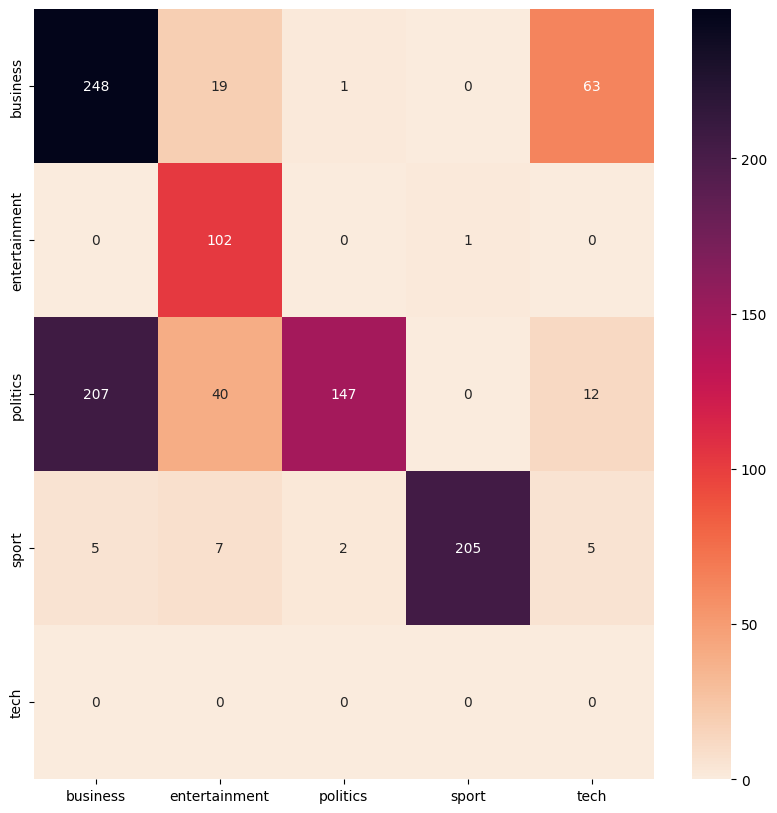

In [93]:
from sklearn import metrics 
from matplotlib import pyplot as plt
import seaborn as sns


matrix = metrics.confusion_matrix(test_df['label'], test_pred)

plt.figure(figsize=(10,10))
ax = sns.heatmap(matrix, annot=True, fmt="d", cmap = 'rocket_r', xticklabels = ['business', 'entertainment', 'politics', 'sport', 'tech']
, yticklabels = ['business', 'entertainment', 'politics', 'sport', 'tech'])

In [94]:
#Evaluating the model with Validation set
estimator.evaluate(input_fn=test_input_fn, steps=None)

INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.
2023-03-12 15:16:11.102495: W tensorflow/core/common_runtime/graph_constructor.cc:1526] Importing a graph with a lower producer version 27 into an existing graph with producer version 1087. Shape inference will have run different parts of the graph with different producer versions.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2023-03-12T15:16:14


INFO:tensorflow:Starting evaluation at 2023-03-12T15:16:14


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from ./bert_news_category/model.ckpt-111


2023-03-12 15:16:14.926150: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-03-12 15:16:14.926184: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
INFO:tensorflow:Restoring parameters from ./bert_news_category/model.ckpt-111
2023-03-12 15:16:15.100194: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Running local_init_op.


2023-03-12 15:16:16.674220: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


2023-03-12 15:16:16.802121: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
INFO:tensorflow:Done running local_init_op.
2023-03-12 15:16:16.838792: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-03-12 15:16:16.955648: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-03-12 15:16:17.002738: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-03-12 15:17:07.511643: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Inference Time : 53.42968s


INFO:tensorflow:Inference Time : 53.42968s


INFO:tensorflow:Finished evaluation at 2023-03-12-15:17:08


INFO:tensorflow:Finished evaluation at 2023-03-12-15:17:08


INFO:tensorflow:Saving dict for global step 111: eval_accuracy = 0.6597745, false_negatives = 212.0, false_positives = 83.0, global_step = 111, loss = 1.0706701, true_negatives = 248.0, true_positives = 521.0


INFO:tensorflow:Saving dict for global step 111: eval_accuracy = 0.6597745, false_negatives = 212.0, false_positives = 83.0, global_step = 111, loss = 1.0706701, true_negatives = 248.0, true_positives = 521.0


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 111: ./bert_news_category/model.ckpt-111


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 111: ./bert_news_category/model.ckpt-111


{'eval_accuracy': 0.6597745,
 'false_negatives': 212.0,
 'false_positives': 83.0,
 'loss': 1.0706701,
 'true_negatives': 248.0,
 'true_positives': 521.0,
 'global_step': 111}